In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import time

Wczytanie i wstępna analiza danych

In [4]:
df = pd.read_csv("jakos_wody_2.csv", index_col=0)
print(df.head(10))

          ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0        NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1   3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2   8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3   8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4   9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   
5   5.584087  188.313324  28748.687739     7.544869  326.678363    280.467916   
6  10.223862  248.071735  28749.716544     7.513408  393.663396    283.651634   
7   8.635849  203.361523  13672.091764     4.563009  303.309771    474.607645   
8        NaN  118.988579  14285.583854     7.804174  268.646941    389.375566   
9  11.180284  227.231469  25484.508491     9.077200  404.041635    563.885481   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135   

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 281.5 KB
None


In [6]:
print(df.describe())

                ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.252442  
std       80.824064        3.308162        16.175008     0.780382     0.434480  


Wizualizacja rozkładu zmiennej docelowej (Potability) i sprawdzenie braku danych 

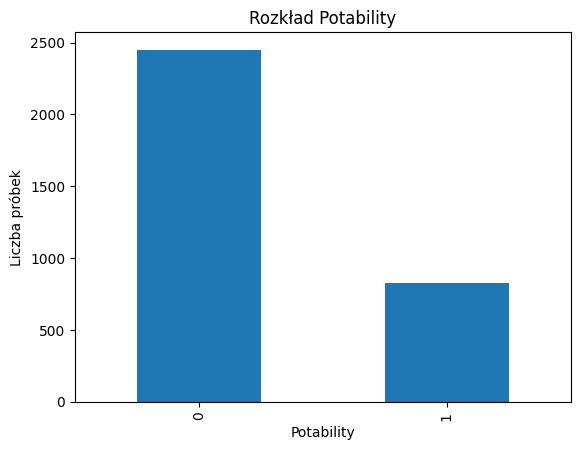

Ilość próbek: 
 Potability
0    2449
1     827
Name: count, dtype: int64
Braki danych:
 ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


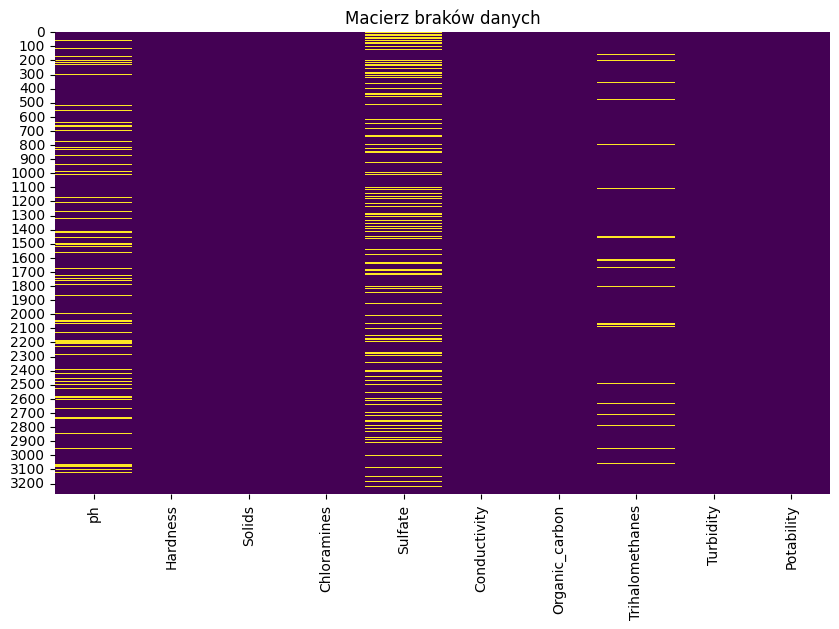

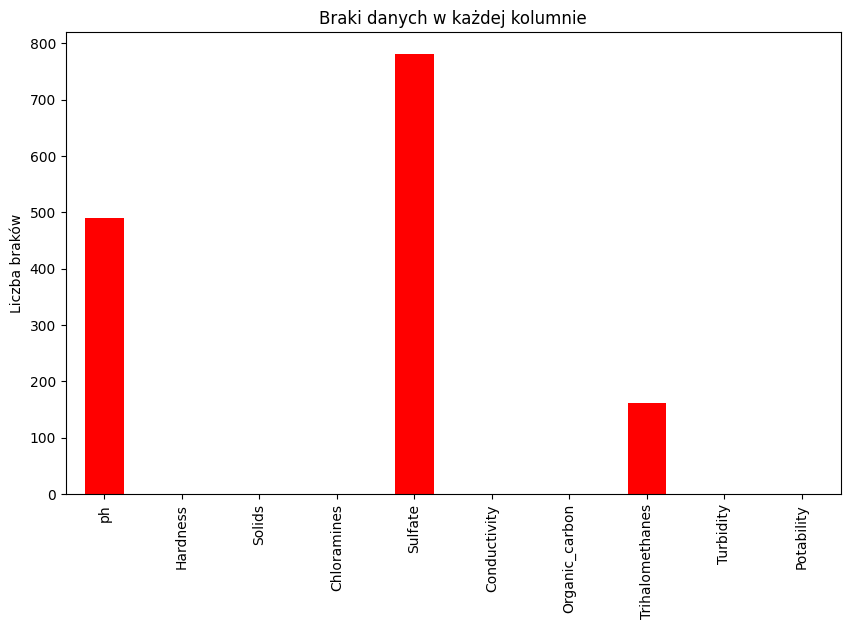

In [7]:
df['Potability'].value_counts().plot(kind='bar')
plt.title('Rozkład Potability')
plt.xlabel('Potability')
plt.ylabel('Liczba próbek')
plt.show()
print("Ilość próbek: \n", df['Potability'].value_counts())

missing_values = df.isnull().sum()
print("Braki danych:\n", missing_values)

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Macierz braków danych')
plt.show()

missing_values.plot(kind='bar', figsize=(10, 6), color='red')
plt.title('Braki danych w każdej kolumnie')
plt.ylabel('Liczba braków')
plt.show()

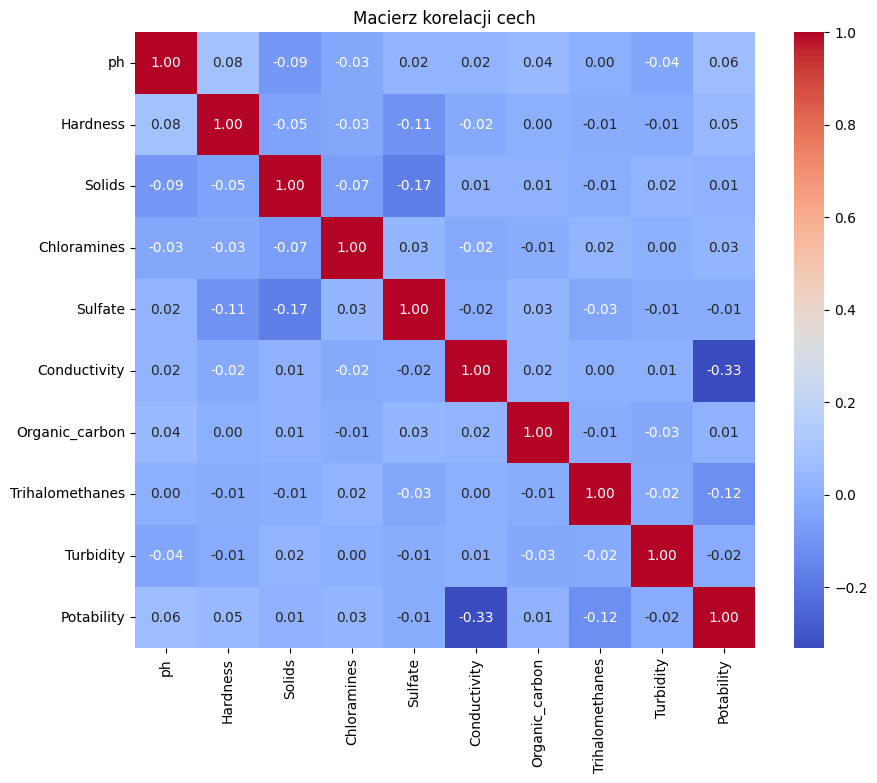

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Macierz korelacji cech")
plt.show()

Wyświetlenie danych, oraz ich normalizacja 

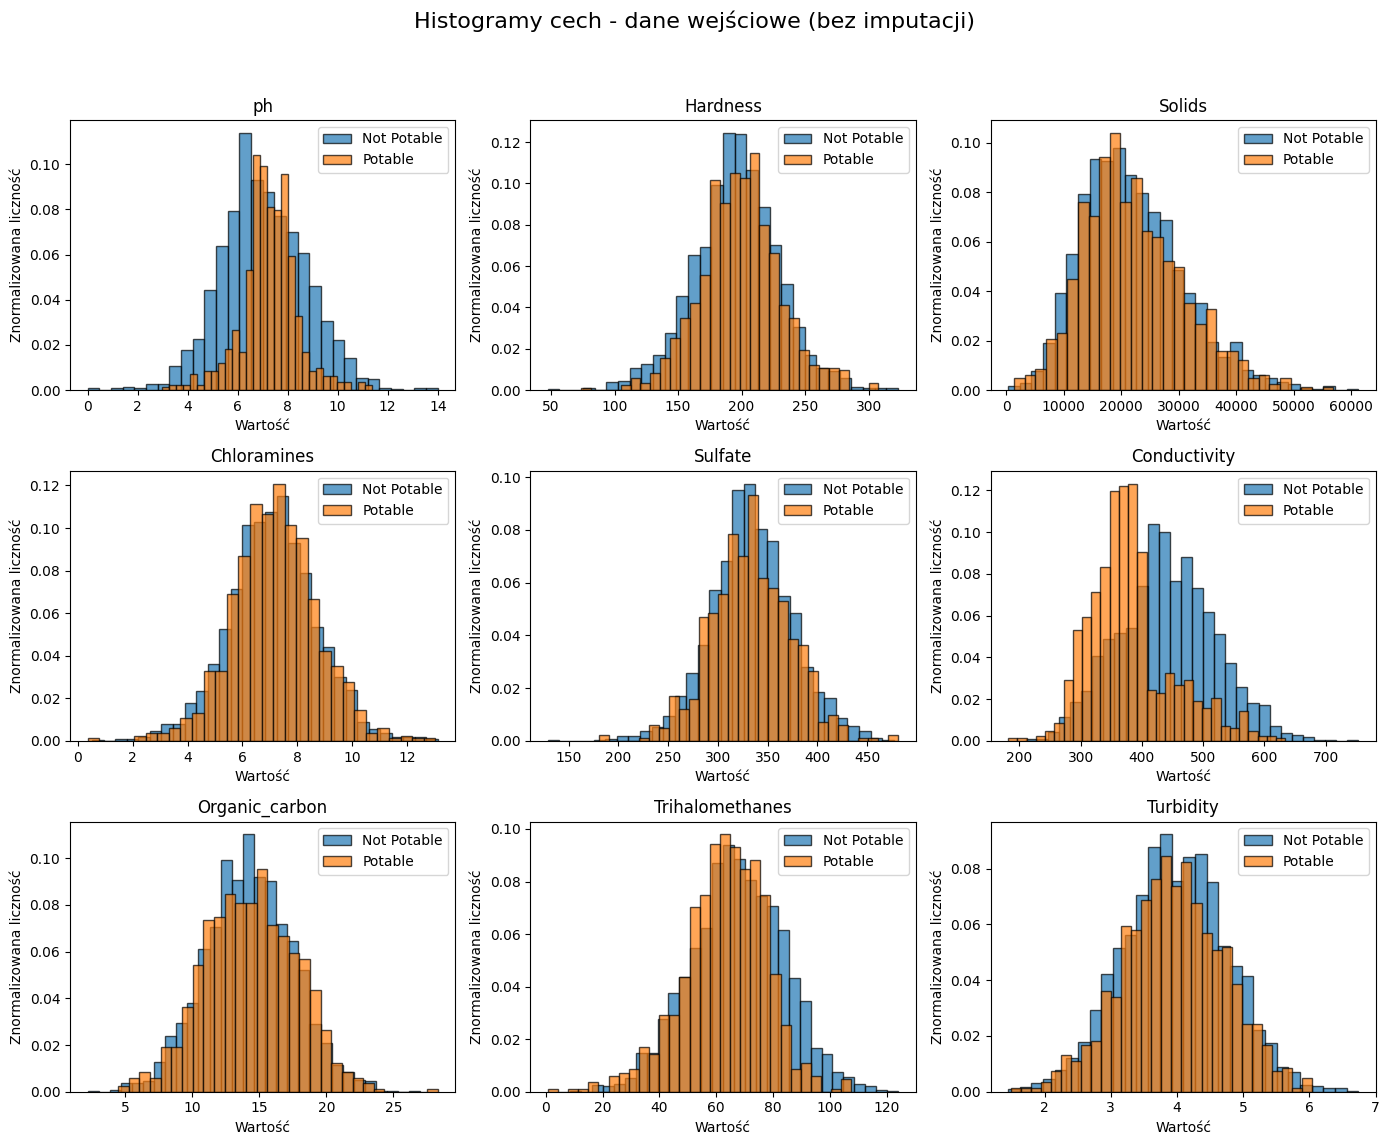

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns[:-1]): 
    ax = axes[i]
    cl0 = df[df["Potability"] == 0][col]
    cl1 = df[df["Potability"] == 1][col]

    # Normalizacja przez liczność klasy
    weights_0 = np.ones_like(cl0) / len(cl0)
    weights_1 = np.ones_like(cl1) / len(cl1)

    ax.hist(cl0, bins=30, alpha=0.7, label="Not Potable", edgecolor='black', weights=weights_0)
    ax.hist(cl1, bins=30, alpha=0.7, label="Potable", edgecolor='black', weights=weights_1)

    ax.set_title(col)
    ax.set_xlabel("Wartość")
    ax.set_ylabel("Znormalizowana liczność")
    ax.legend()

plt.suptitle("Histogramy cech - dane wejściowe (bez imputacji)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [10]:

df_mean = df.copy()
df_median = df.copy()
df_mode = df.copy()
df_knn_5 = df.copy()
df_knn_10 = df.copy()
df_knn_20 = df.copy()
df_iter_5 = df.copy()
df_iter_10 = df.copy()
df_iter_dt = df.copy()
df_iter_rf = df.copy()

imputation_times = {}

def time_imputation(name, func, df_target):
    start = time.time()
    df_target.iloc[:, :-1] = func()
    duration = time.time() - start
    imputation_times[name] = duration
    print(f"Imputacja {name}: {duration:.3f} sekundy")

# df_mean.iloc[:, :-1] = SimpleImputer(strategy="mean").fit_transform(df_mean.iloc[:, :-1])
# df_median.iloc[:, :-1] = SimpleImputer(strategy="median").fit_transform(df_median.iloc[:, :-1])
# df_mode.iloc[:, :-1] = SimpleImputer(strategy="most_frequent").fit_transform(df_mode.iloc[:, :-1])
# df_knn_5.iloc[:, :-1] = KNNImputer(n_neighbors=5).fit_transform(df_knn_5.iloc[:, :-1])
# df_knn_10.iloc[:, :-1] = KNNImputer(n_neighbors=10).fit_transform(df_knn_10.iloc[:, :-1])
# df_knn_20.iloc[:, :-1] = KNNImputer(n_neighbors=20).fit_transform(df_knn_20.iloc[:, :-1])
# df_iter_5.iloc[:, :-1] = IterativeImputer(max_iter=5, random_state=42).fit_transform(df_iter_5.iloc[:, :-1])
# df_iter_10.iloc[:, :-1] = IterativeImputer(max_iter=10, random_state=42).fit_transform(df_iter_10.iloc[:, :-1])
# df_iter_dt.iloc[:, :-1] = IterativeImputer(estimator=DecisionTreeRegressor(max_depth=5), random_state=42).fit_transform(df_iter_dt.iloc[:, :-1])
# df_iter_rf.iloc[:, :-1] = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=42).fit_transform(df_iter_rf.iloc[:, :-1])

time_imputation("mean", lambda: SimpleImputer(strategy="mean").fit_transform(df_mean.iloc[:, :-1]), df_mean)
time_imputation("median", lambda: SimpleImputer(strategy="median").fit_transform(df_median.iloc[:, :-1]), df_median)
time_imputation("mode", lambda: SimpleImputer(strategy="most_frequent").fit_transform(df_mode.iloc[:, :-1]), df_mode)
time_imputation("knn_5", lambda: KNNImputer(n_neighbors=5).fit_transform(df_knn_5.iloc[:, :-1]), df_knn_5)
time_imputation("knn_10", lambda: KNNImputer(n_neighbors=10).fit_transform(df_knn_10.iloc[:, :-1]), df_knn_10)
time_imputation("knn_20", lambda: KNNImputer(n_neighbors=20).fit_transform(df_knn_20.iloc[:, :-1]), df_knn_20)
time_imputation("iter_5", lambda: IterativeImputer(max_iter=5, random_state=42).fit_transform(df_iter_5.iloc[:, :-1]), df_iter_5)
time_imputation("iter_10", lambda: IterativeImputer(max_iter=10, random_state=42).fit_transform(df_iter_10.iloc[:, :-1]), df_iter_10)
time_imputation("iter_dt", lambda: IterativeImputer(estimator=DecisionTreeRegressor(max_depth=5), random_state=42).fit_transform(df_iter_dt.iloc[:, :-1]), df_iter_dt)
time_imputation("iter_rf", lambda: IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=42).fit_transform(df_iter_rf.iloc[:, :-1]), df_iter_rf)

scaler = MinMaxScaler()
df_mean.iloc[:, :-1] = MinMaxScaler().fit_transform(df_mean.iloc[:, :-1])
df_median.iloc[:, :-1] = MinMaxScaler().fit_transform(df_median.iloc[:, :-1])
df_mode.iloc[:, :-1] = MinMaxScaler().fit_transform(df_mode.iloc[:, :-1])
df_knn_5.iloc[:, :-1] = MinMaxScaler().fit_transform(df_knn_5.iloc[:, :-1])
df_knn_10.iloc[:, :-1] = MinMaxScaler().fit_transform(df_knn_10.iloc[:, :-1])
df_knn_20.iloc[:, :-1] = MinMaxScaler().fit_transform(df_knn_20.iloc[:, :-1])
df_iter_5.iloc[:, :-1] = MinMaxScaler().fit_transform(df_iter_5.iloc[:, :-1])
df_iter_10.iloc[:, :-1] = MinMaxScaler().fit_transform(df_iter_10.iloc[:, :-1])
df_iter_dt.iloc[:, :-1] = MinMaxScaler().fit_transform(df_iter_dt.iloc[:, :-1])
df_iter_rf.iloc[:, :-1] = MinMaxScaler().fit_transform(df_iter_rf.iloc[:, :-1])

df_mean_no_ph = df_mean.drop(columns=["ph"])
df_median_no_ph = df_median.drop(columns=["ph"])
df_mode_no_ph = df_mode.drop(columns=["ph"])
df_knn_5_no_ph = df_knn_5.drop(columns=["ph"])
df_knn_10_no_ph = df_knn_10.drop(columns=["ph"])
df_knn_20_no_ph = df_knn_20.drop(columns=["ph"])
df_iter_5_no_ph = df_iter_5.drop(columns=["ph"])
df_iter_10_no_ph = df_iter_10.drop(columns=["ph"])
df_iter_dt_no_ph = df_iter_dt.drop(columns=["ph"])
df_iter_rf_no_ph = df_iter_rf.drop(columns=["ph"])

df_mean_no_sulfate = df_mean.drop(columns=["Sulfate"])
df_median_no_sulfate = df_median.drop(columns=["Sulfate"])
df_mode_no_sulfate = df_mode.drop(columns=["Sulfate"])
df_knn_5_no_sulfate = df_knn_5.drop(columns=["Sulfate"])
df_knn_10_no_sulfate = df_knn_10.drop(columns=["Sulfate"])
df_knn_20_no_sulfate = df_knn_20.drop(columns=["Sulfate"])
df_iter_5_no_sulfate = df_iter_5.drop(columns=["Sulfate"])
df_iter_10_no_sulfate = df_iter_10.drop(columns=["Sulfate"])
df_iter_dt_no_sulfate = df_iter_dt.drop(columns=["Sulfate"])
df_iter_rf_no_sulfate = df_iter_rf.drop(columns=["Sulfate"])

df_mean_no_trihalo = df_mean.drop(columns=["Trihalomethanes"])
df_median_no_trihalo = df_median.drop(columns=["Trihalomethanes"])
df_mode_no_trihalo = df_mode.drop(columns=["Trihalomethanes"])
df_knn_5_no_trihalo = df_knn_5.drop(columns=["Trihalomethanes"])
df_knn_10_no_trihalo = df_knn_10.drop(columns=["Trihalomethanes"])
df_knn_20_no_trihalo = df_knn_20.drop(columns=["Trihalomethanes"])
df_iter_5_no_trihalo = df_iter_5.drop(columns=["Trihalomethanes"])
df_iter_10_no_trihalo = df_iter_10.drop(columns=["Trihalomethanes"])
df_iter_dt_no_trihalo = df_iter_dt.drop(columns=["Trihalomethanes"])
df_iter_rf_no_trihalo = df_iter_rf.drop(columns=["Trihalomethanes"])

df_no_all = df.drop(columns=["ph", "Sulfate", "Trihalomethanes"])


Imputacja mean: 0.000 sekundy
Imputacja median: 0.000 sekundy
Imputacja mode: 0.003 sekundy
Imputacja knn_5: 0.113 sekundy
Imputacja knn_10: 0.119 sekundy
Imputacja knn_20: 0.116 sekundy
Imputacja iter_5: 0.017 sekundy
Imputacja iter_10: 0.009 sekundy
Imputacja iter_dt: 0.168 sekundy
Imputacja iter_rf: 55.576 sekundy


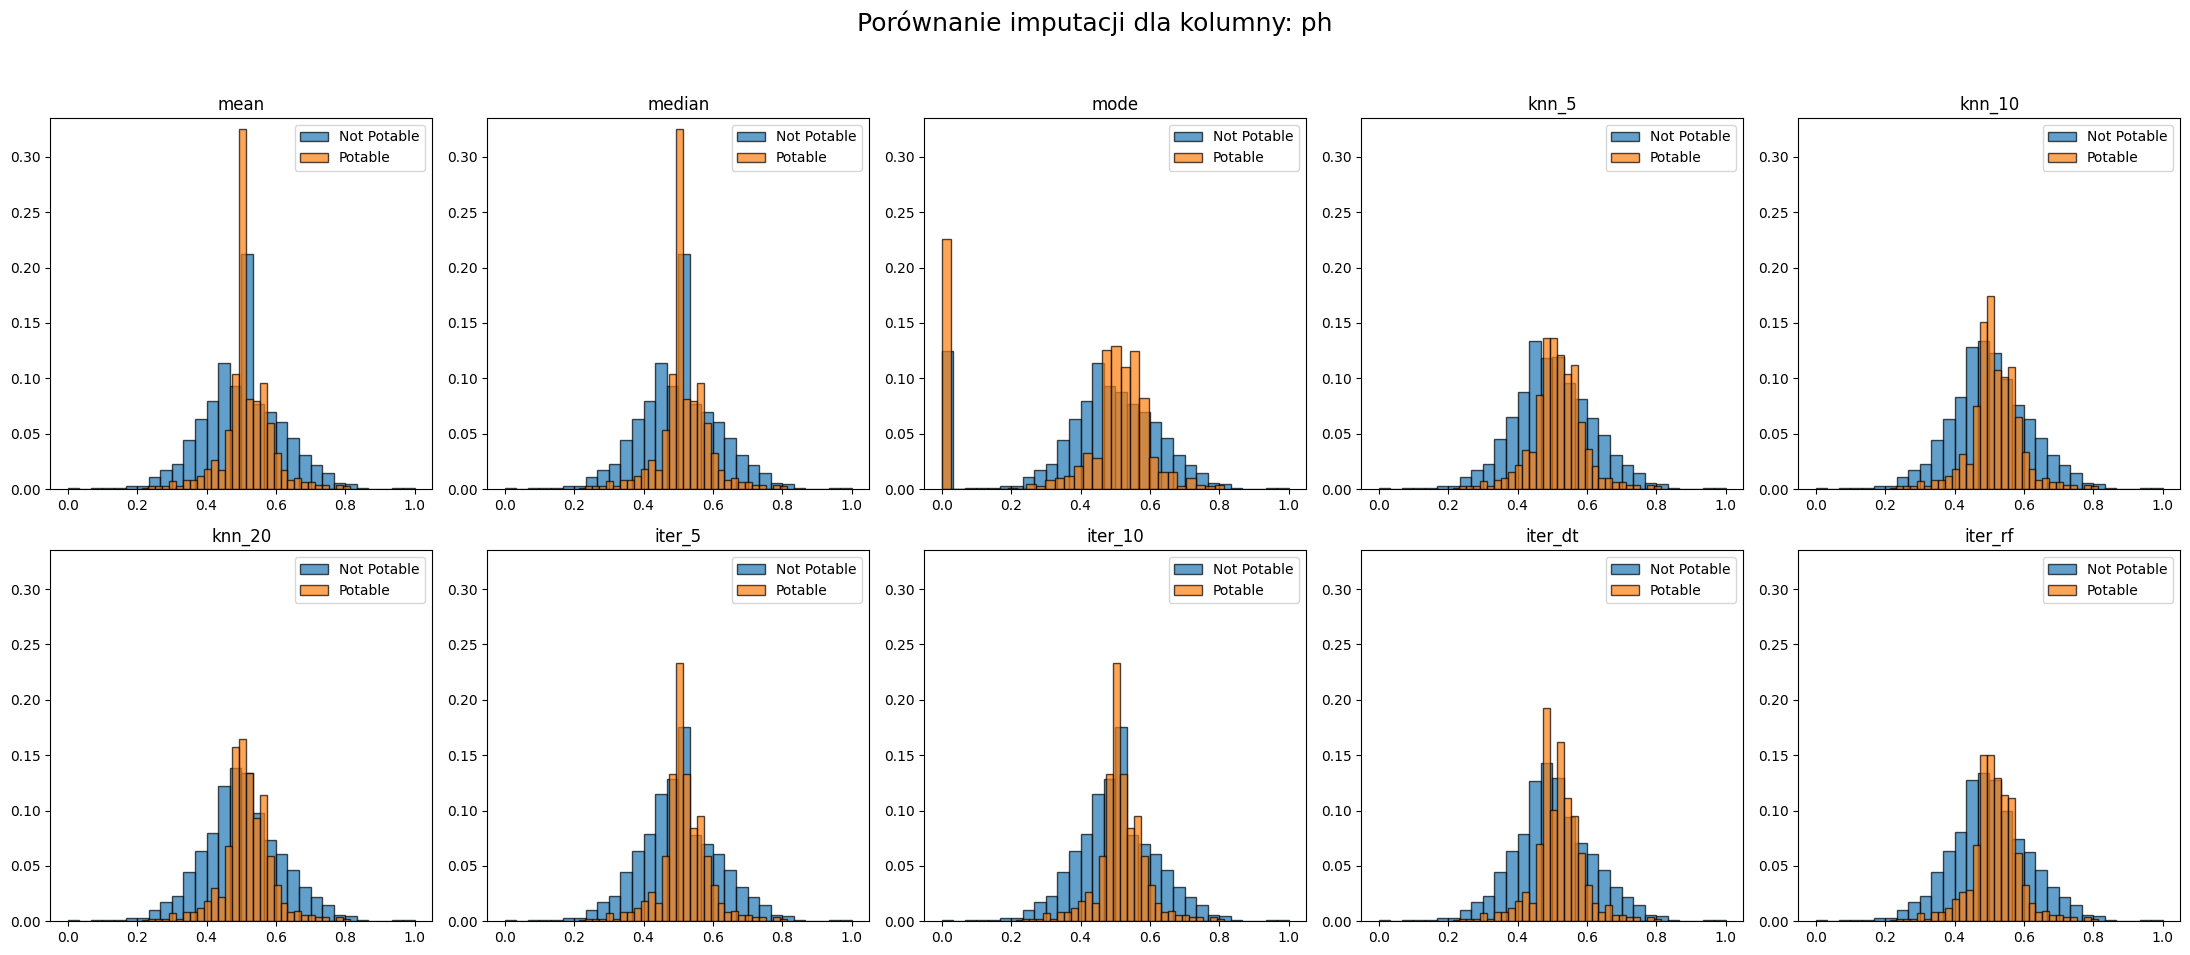

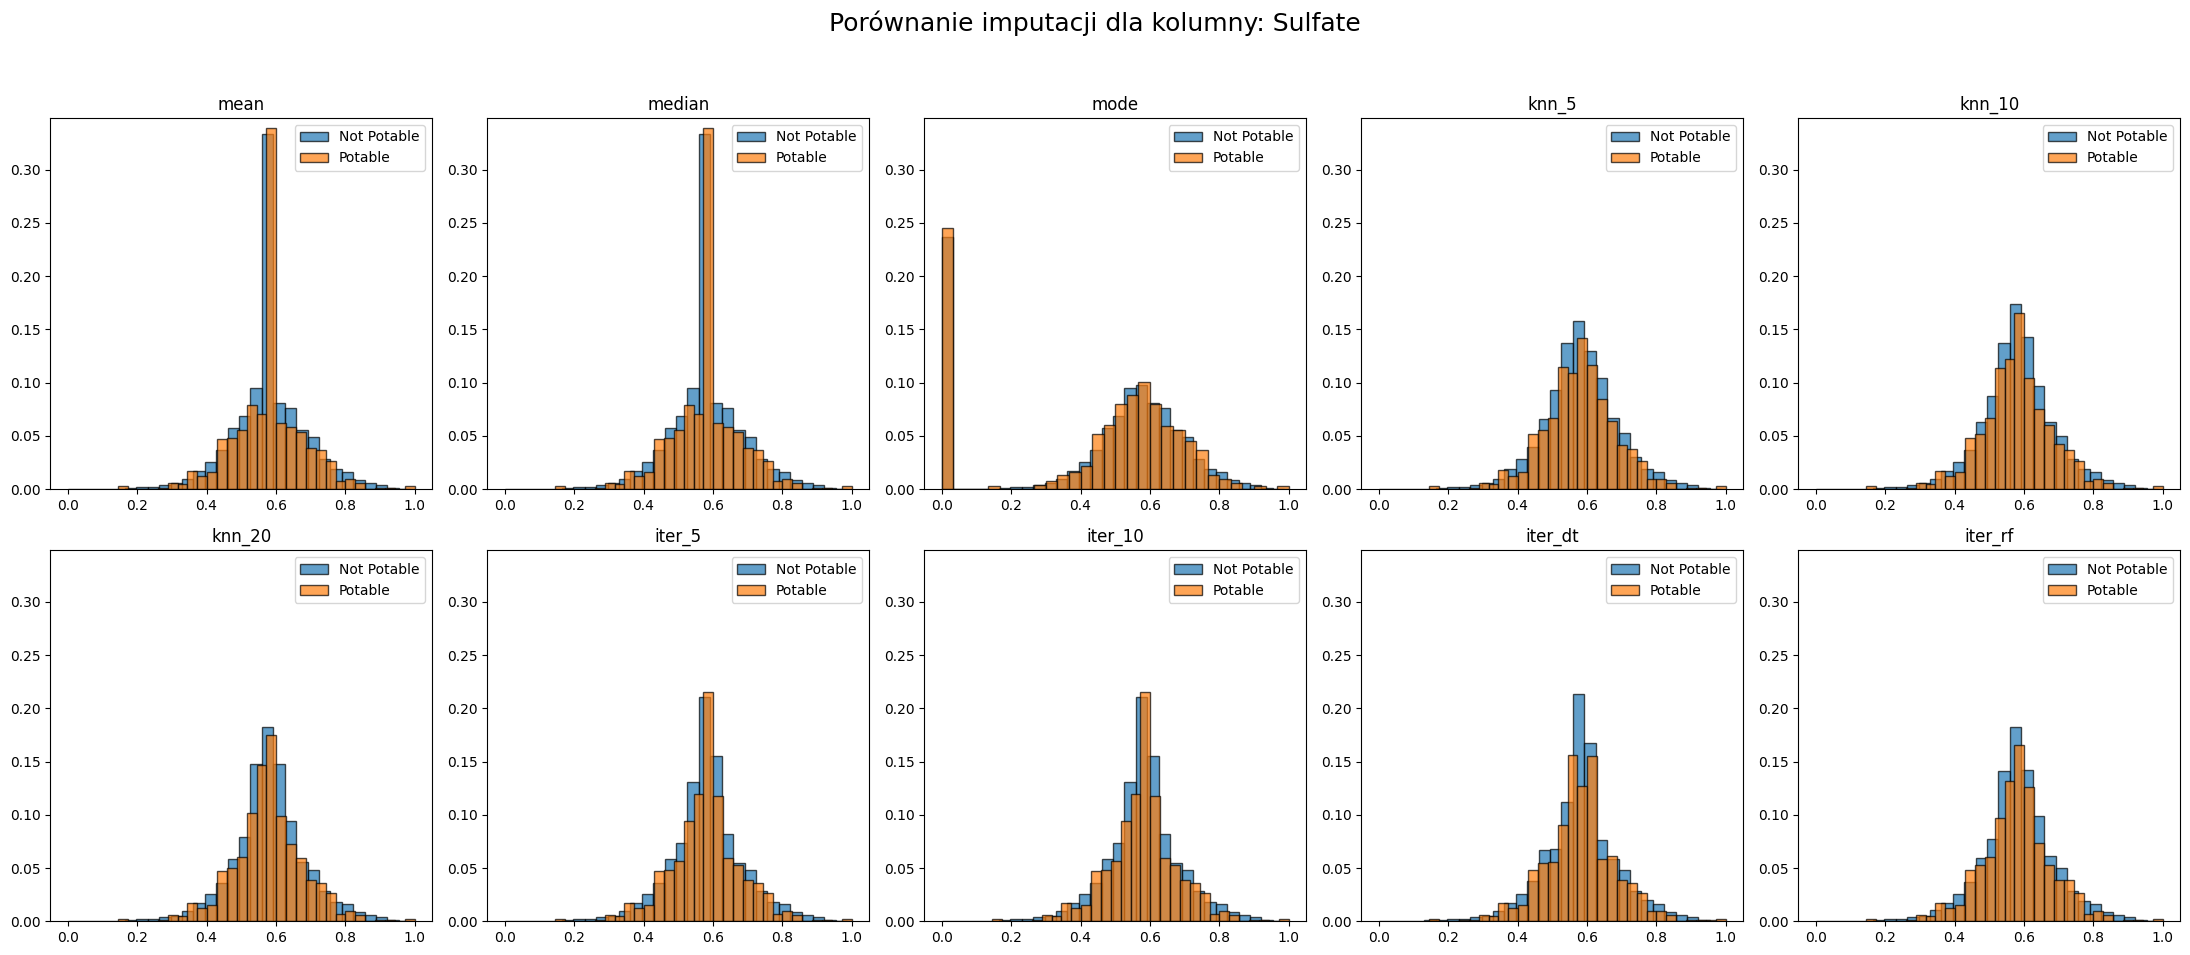

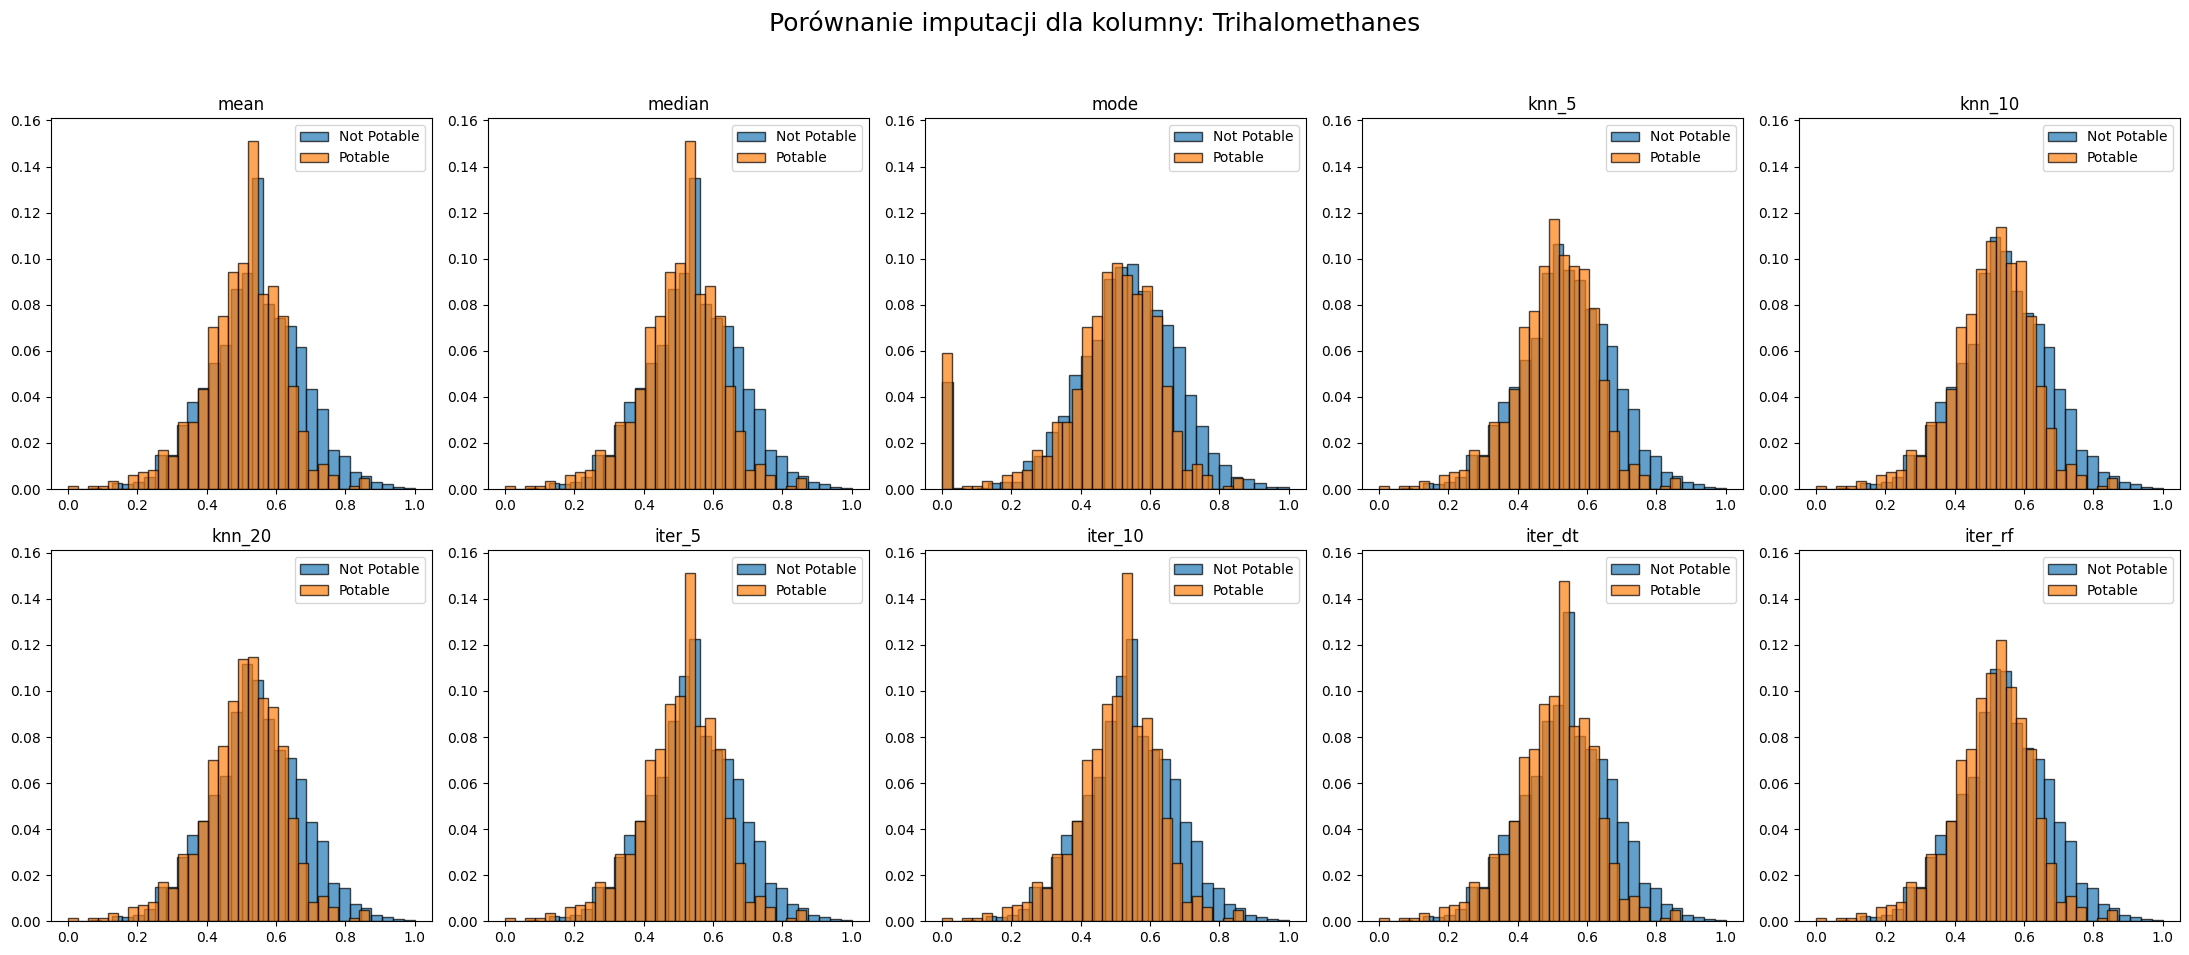

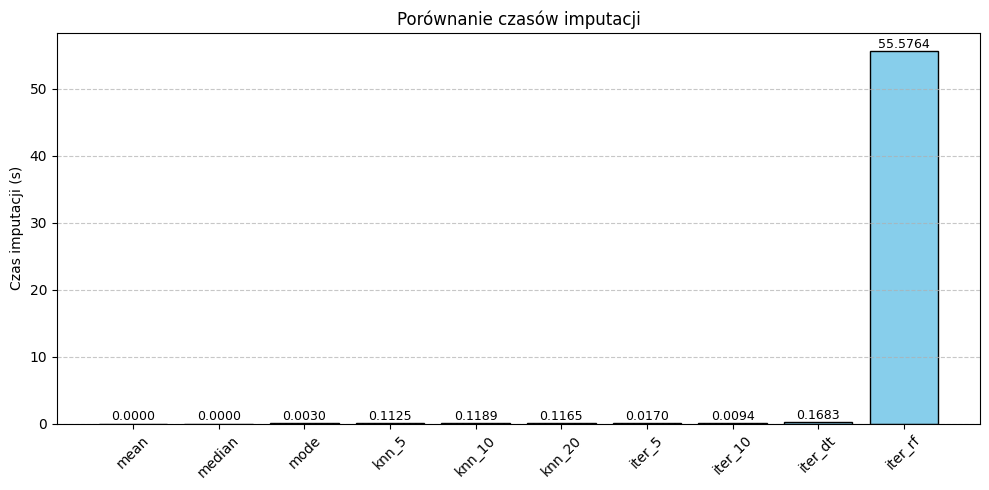

In [11]:
df_list_ph = {
    "mean": df_mean,
    "median": df_median,
    "mode": df_mode,
    "knn_5": df_knn_5,
    "knn_10": df_knn_10,
    "knn_20": df_knn_20,
    "iter_5": df_iter_5,
    "iter_10": df_iter_10,
    "iter_dt": df_iter_dt,
    "iter_rf": df_iter_rf,
}

def plot_histograms(df_dict, colname):
    fig, axes = plt.subplots(2, 5, figsize=(22, 10))
    axes = axes.flatten()

    global_max = 0

    for label, df in df_dict.items():
        if colname not in df.columns:
            continue

        cl0 = df[df["Potability"] == 0][colname].dropna()
        cl1 = df[df["Potability"] == 1][colname].dropna()

        weights_0 = np.ones_like(cl0) / len(cl0) if len(cl0) > 0 else None
        weights_1 = np.ones_like(cl1) / len(cl1) if len(cl1) > 0 else None

        if weights_0 is not None:
            hist0, _ = np.histogram(cl0, bins=30, weights=weights_0)
            global_max = max(global_max, hist0.max())
        if weights_1 is not None:
            hist1, _ = np.histogram(cl1, bins=30, weights=weights_1)
            global_max = max(global_max, hist1.max())

    index = 0
    for label, df in df_dict.items():
        if colname not in df.columns:
            continue

        cl0 = df[df["Potability"] == 0][colname].dropna()
        cl1 = df[df["Potability"] == 1][colname].dropna()

        weights_0 = np.ones_like(cl0) / len(cl0) if len(cl0) > 0 else None
        weights_1 = np.ones_like(cl1) / len(cl1) if len(cl1) > 0 else None

        ax = axes[index]
        ax.hist(cl0, bins=30, alpha=0.7, label='Not Potable', edgecolor='black', weights=weights_0)
        ax.hist(cl1, bins=30, alpha=0.7, label='Potable', edgecolor='black', weights=weights_1)
        ax.set_ylim(0, global_max + 0.01)
        ax.set_title(label)
        ax.legend()
        index += 1

    plt.suptitle(f'Porównanie imputacji dla kolumny: {colname}', fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_histograms(df_list_ph, "ph")
plot_histograms(df_list_ph, "Sulfate")
plot_histograms(df_list_ph, "Trihalomethanes")

plt.figure(figsize=(10, 5))
bars = plt.bar(imputation_times.keys(), imputation_times.values(), color='skyblue', edgecolor='black')
plt.ylabel("Czas imputacji (s)")
plt.title("Porównanie czasów imputacji")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.4f}", ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


c:\Users\kacpe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


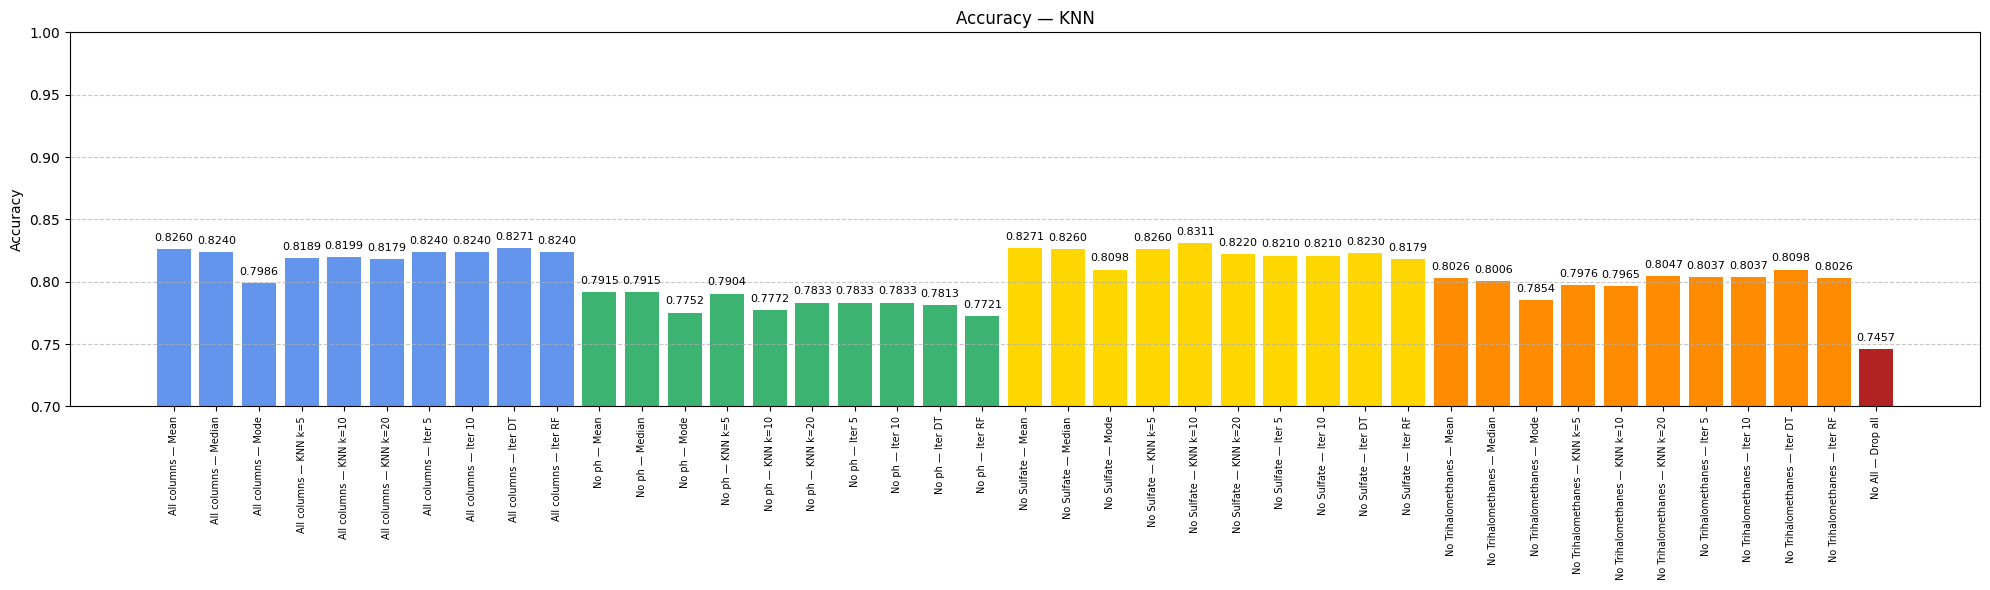

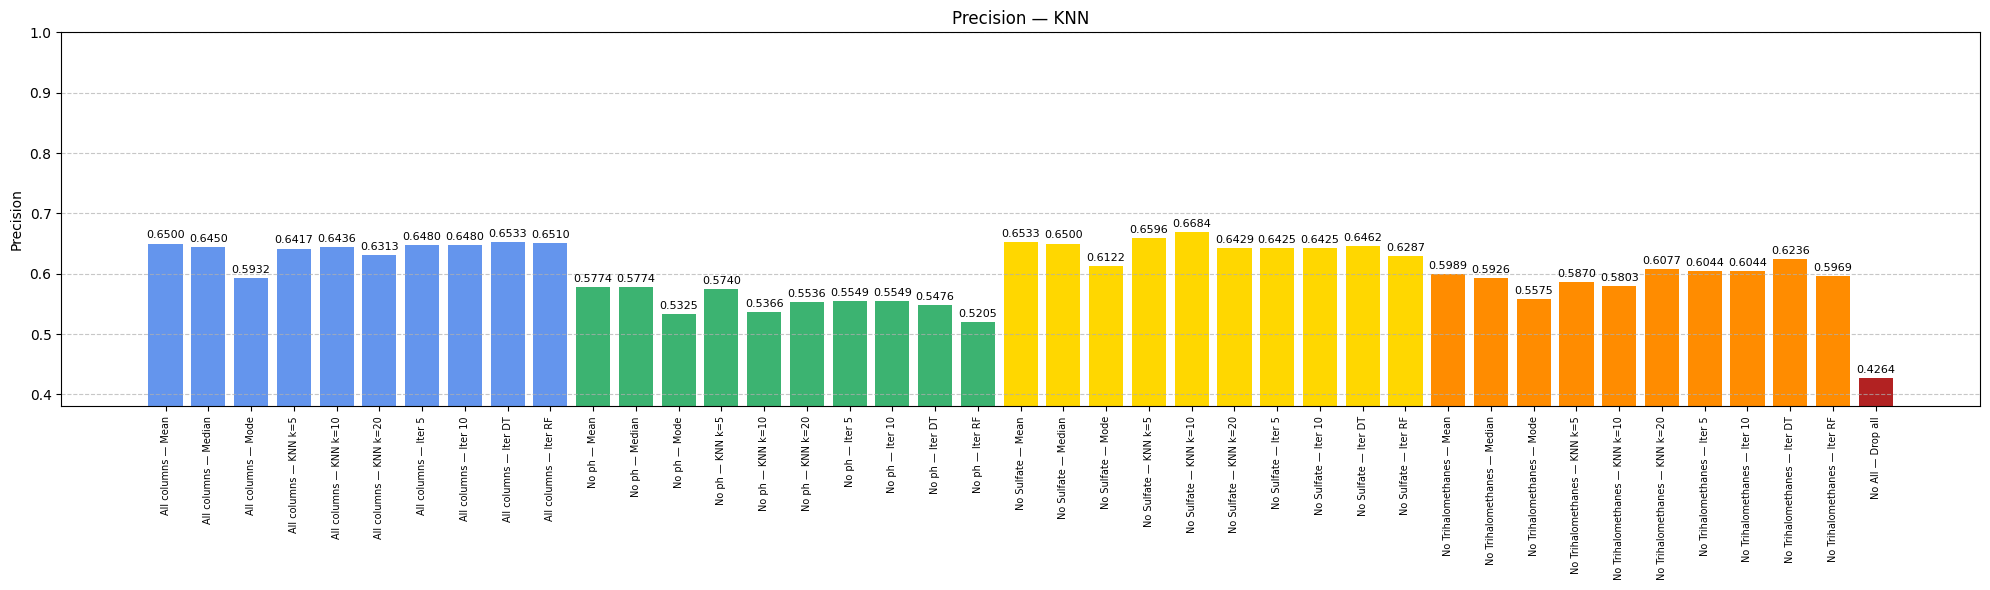

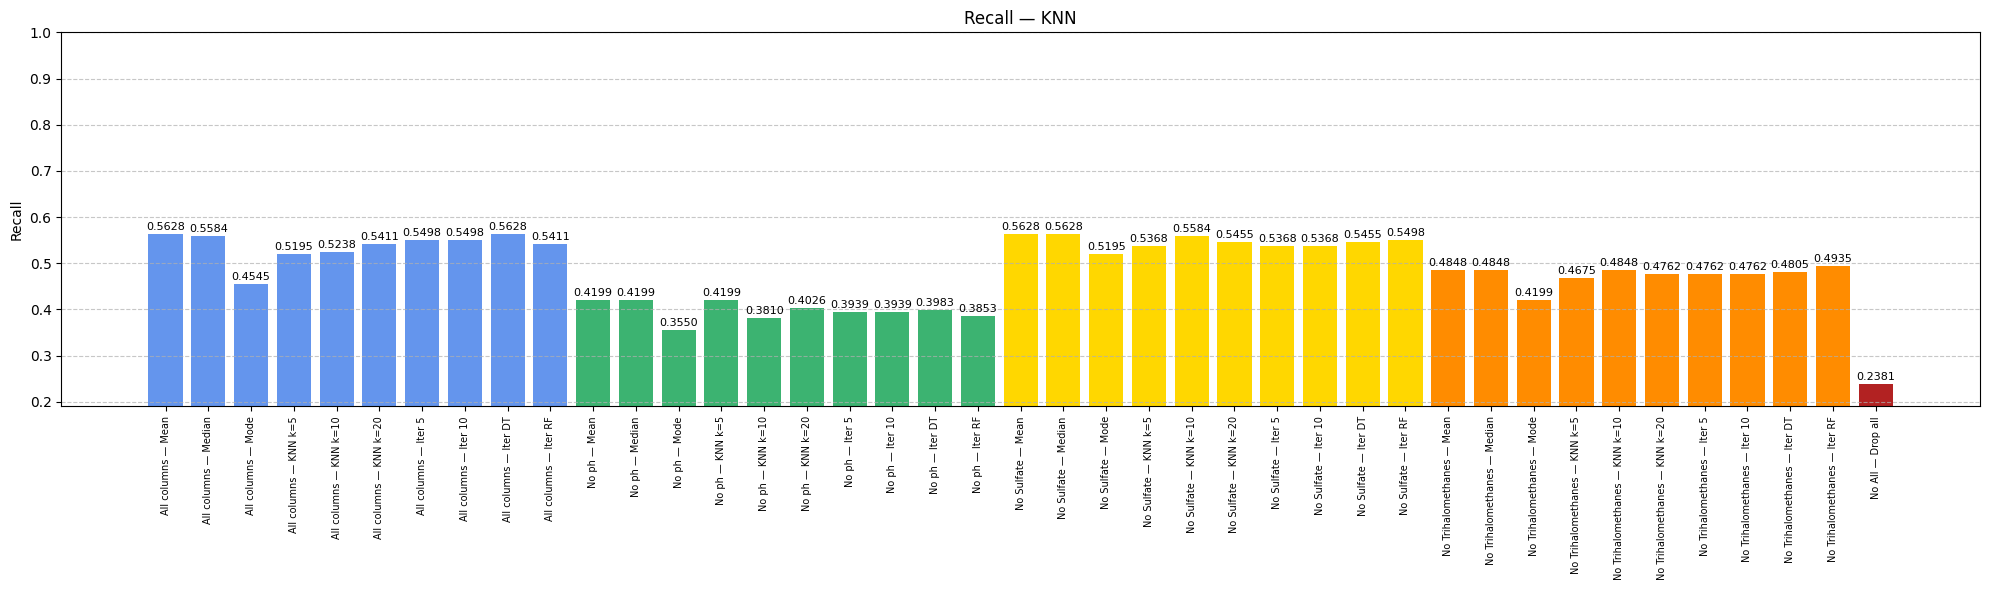

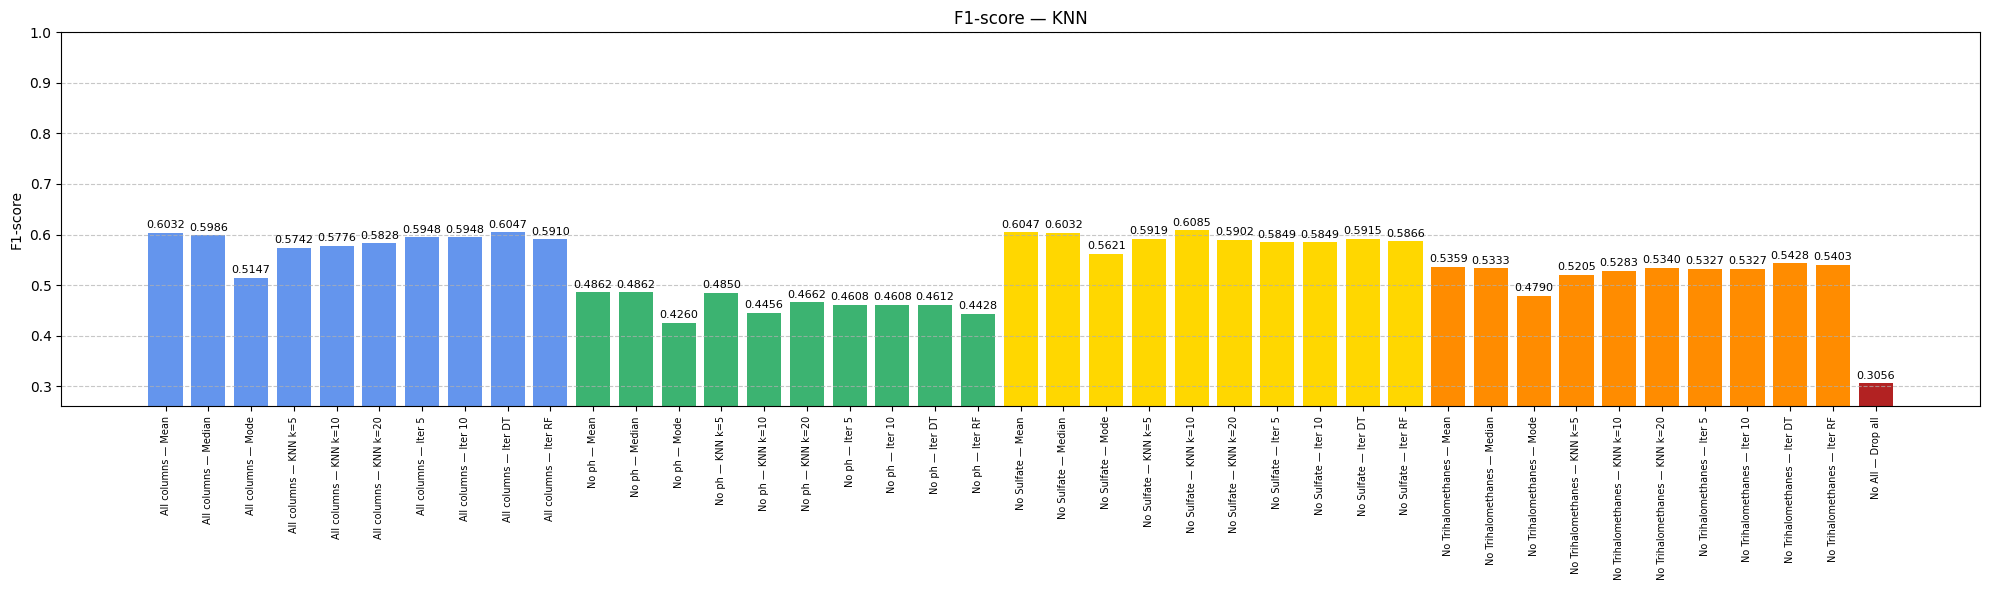


Macierze pomyłek — KNN


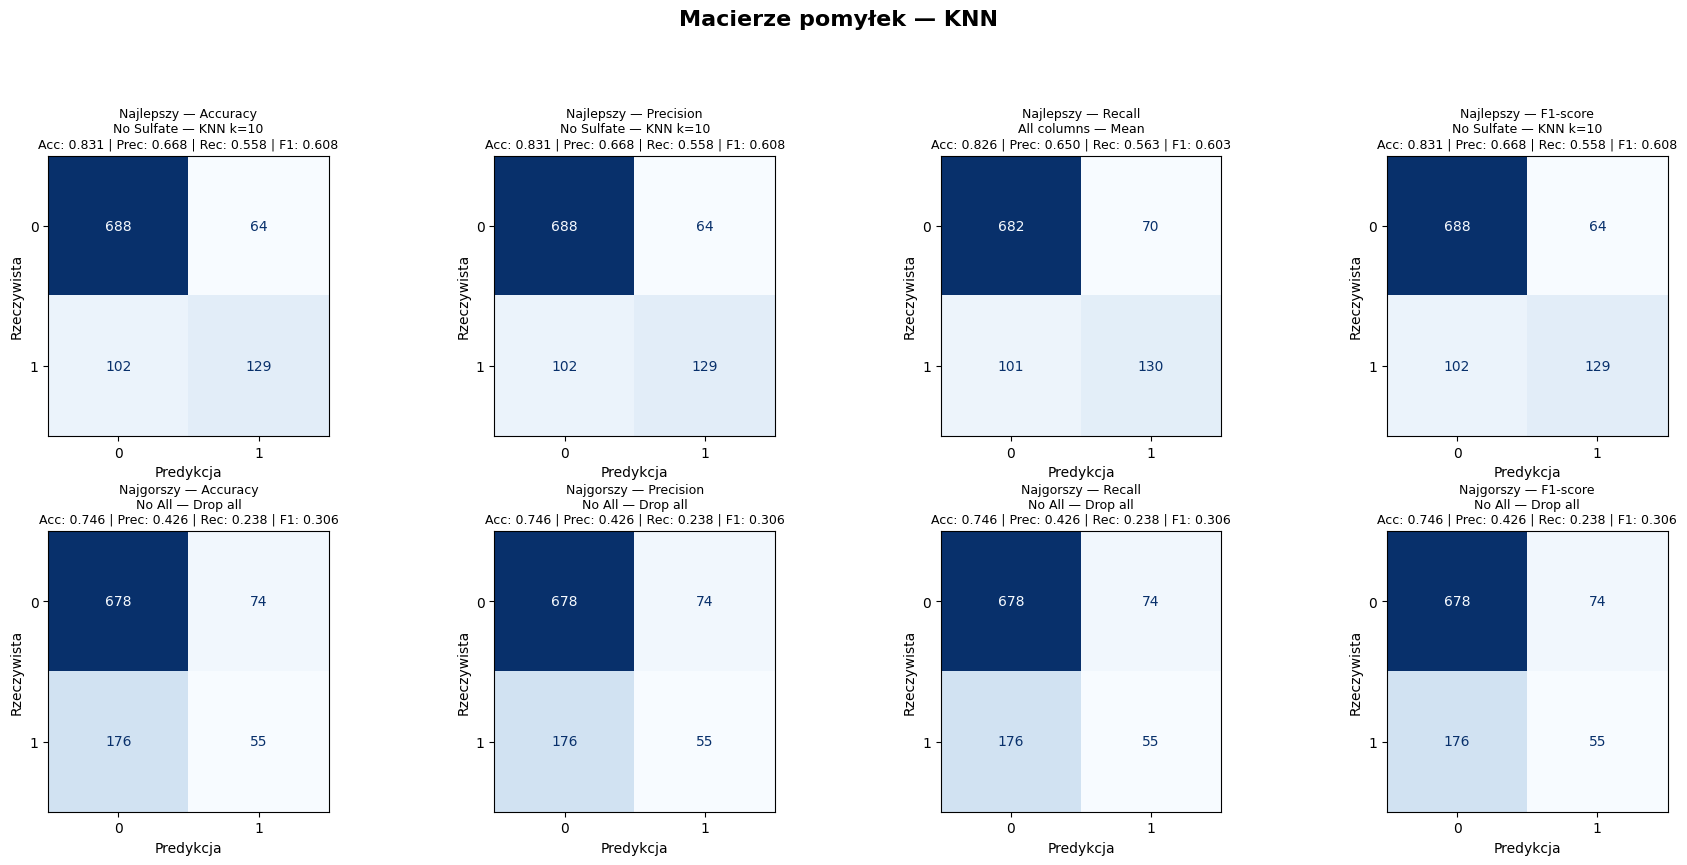

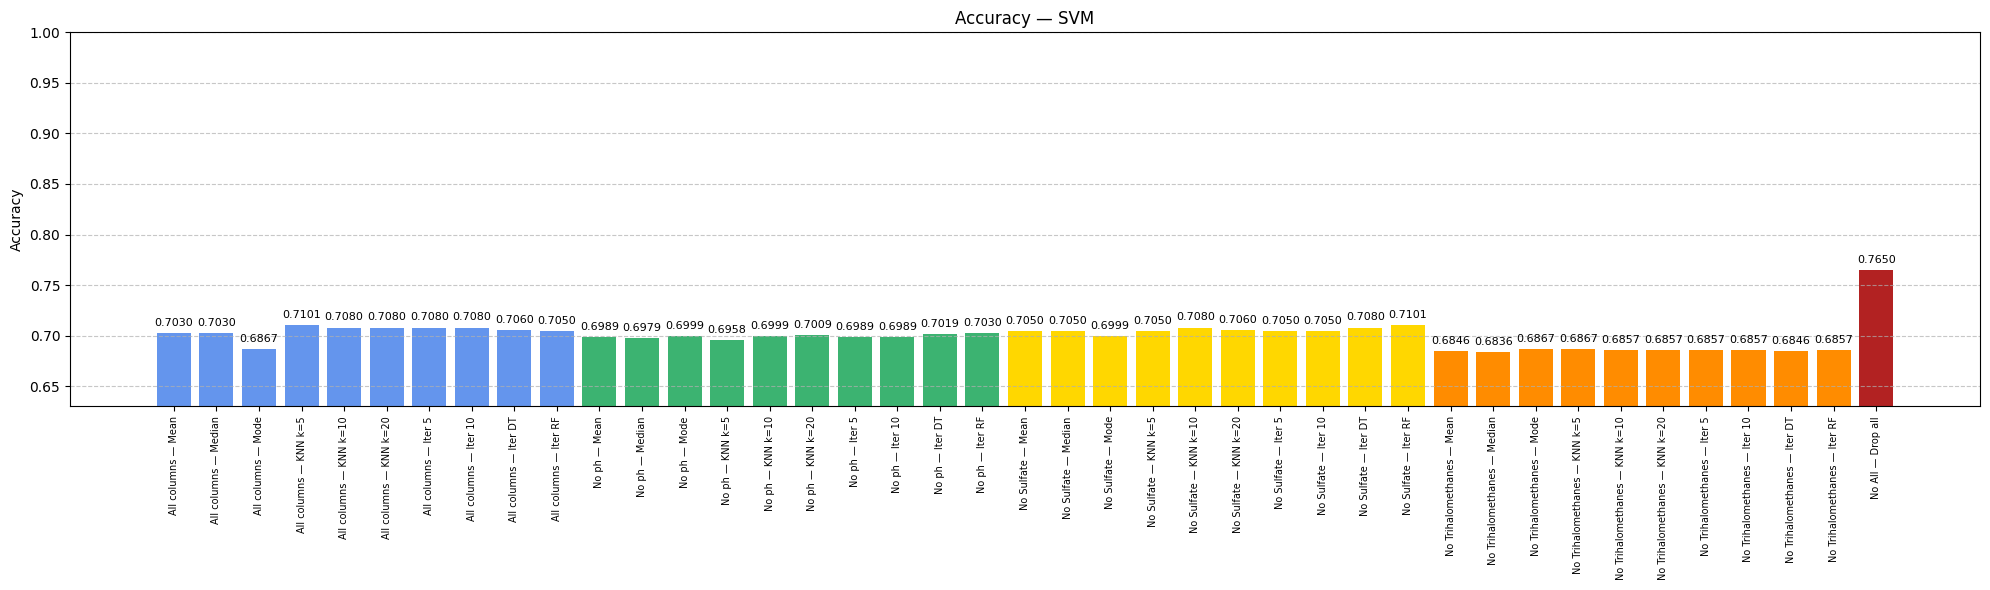

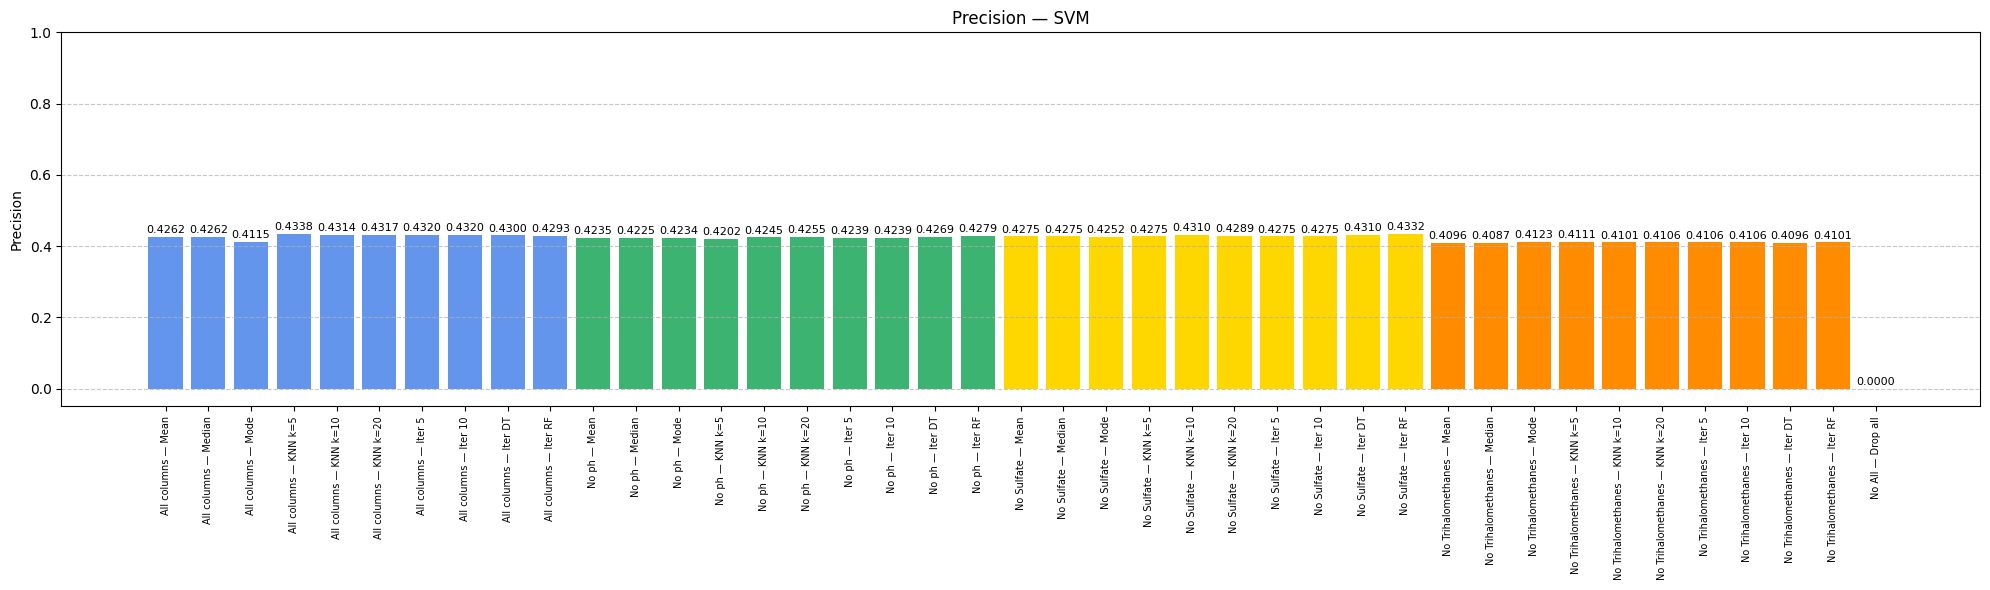

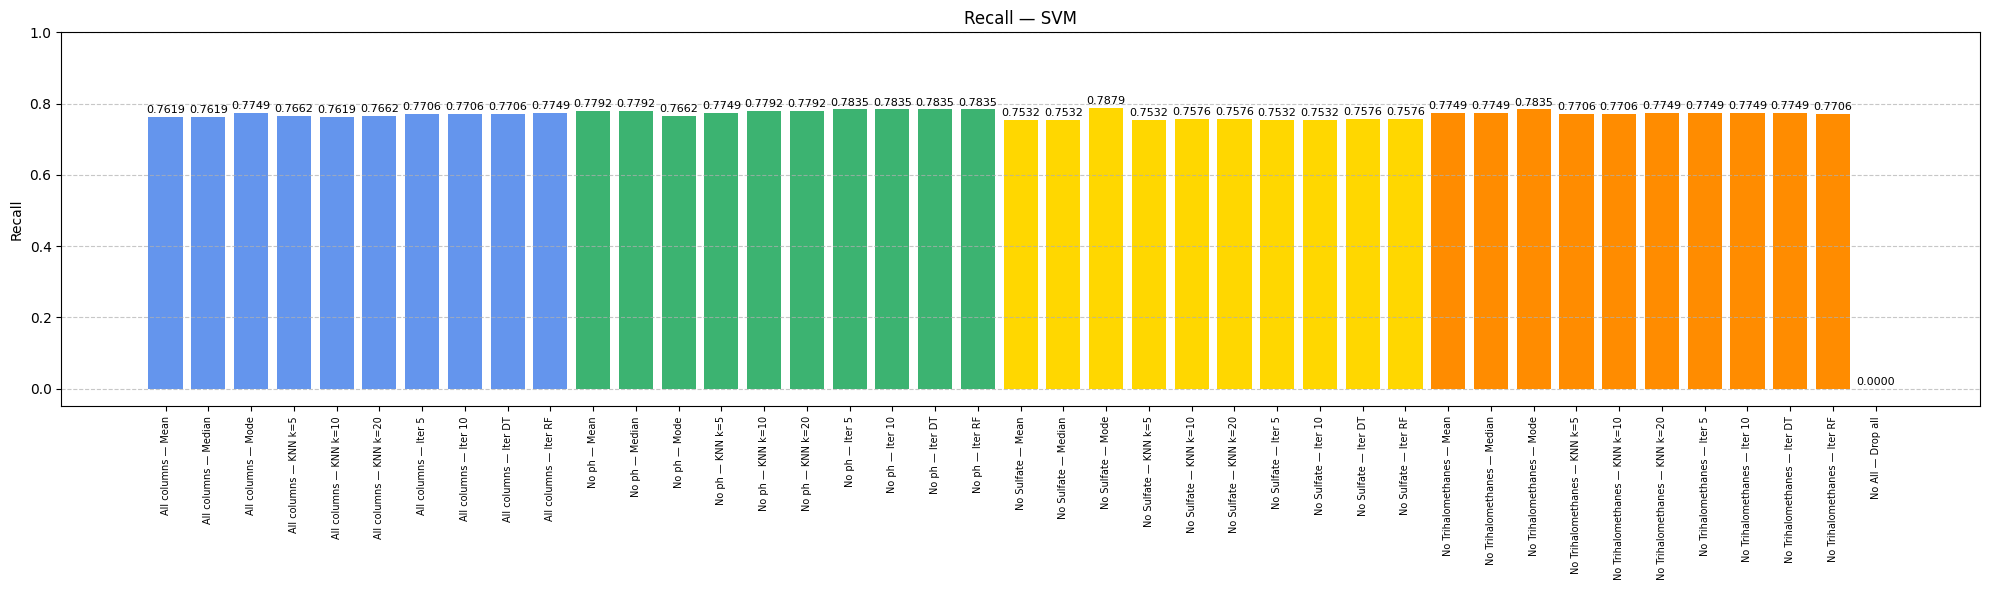

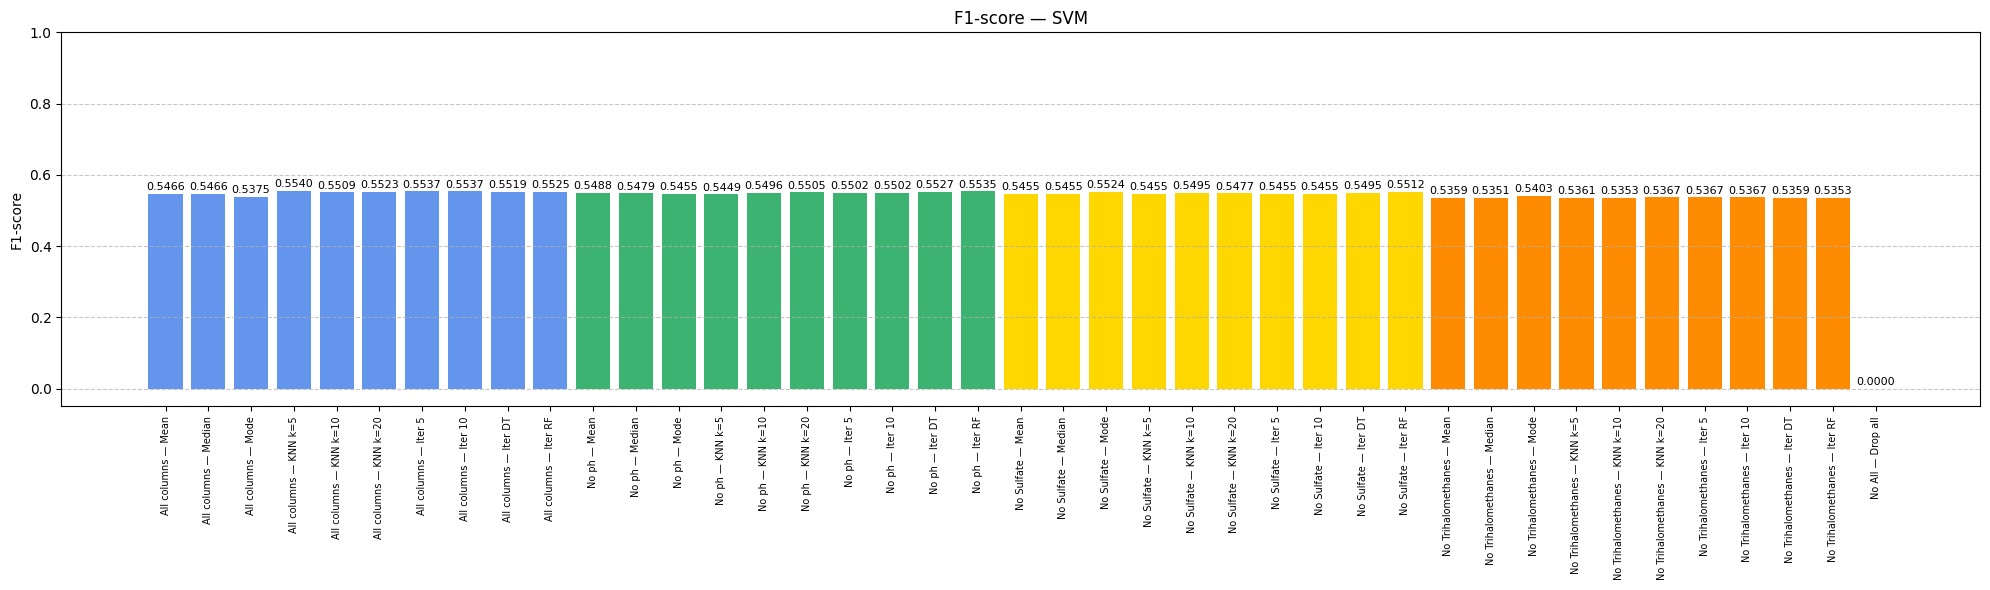


Macierze pomyłek — SVM


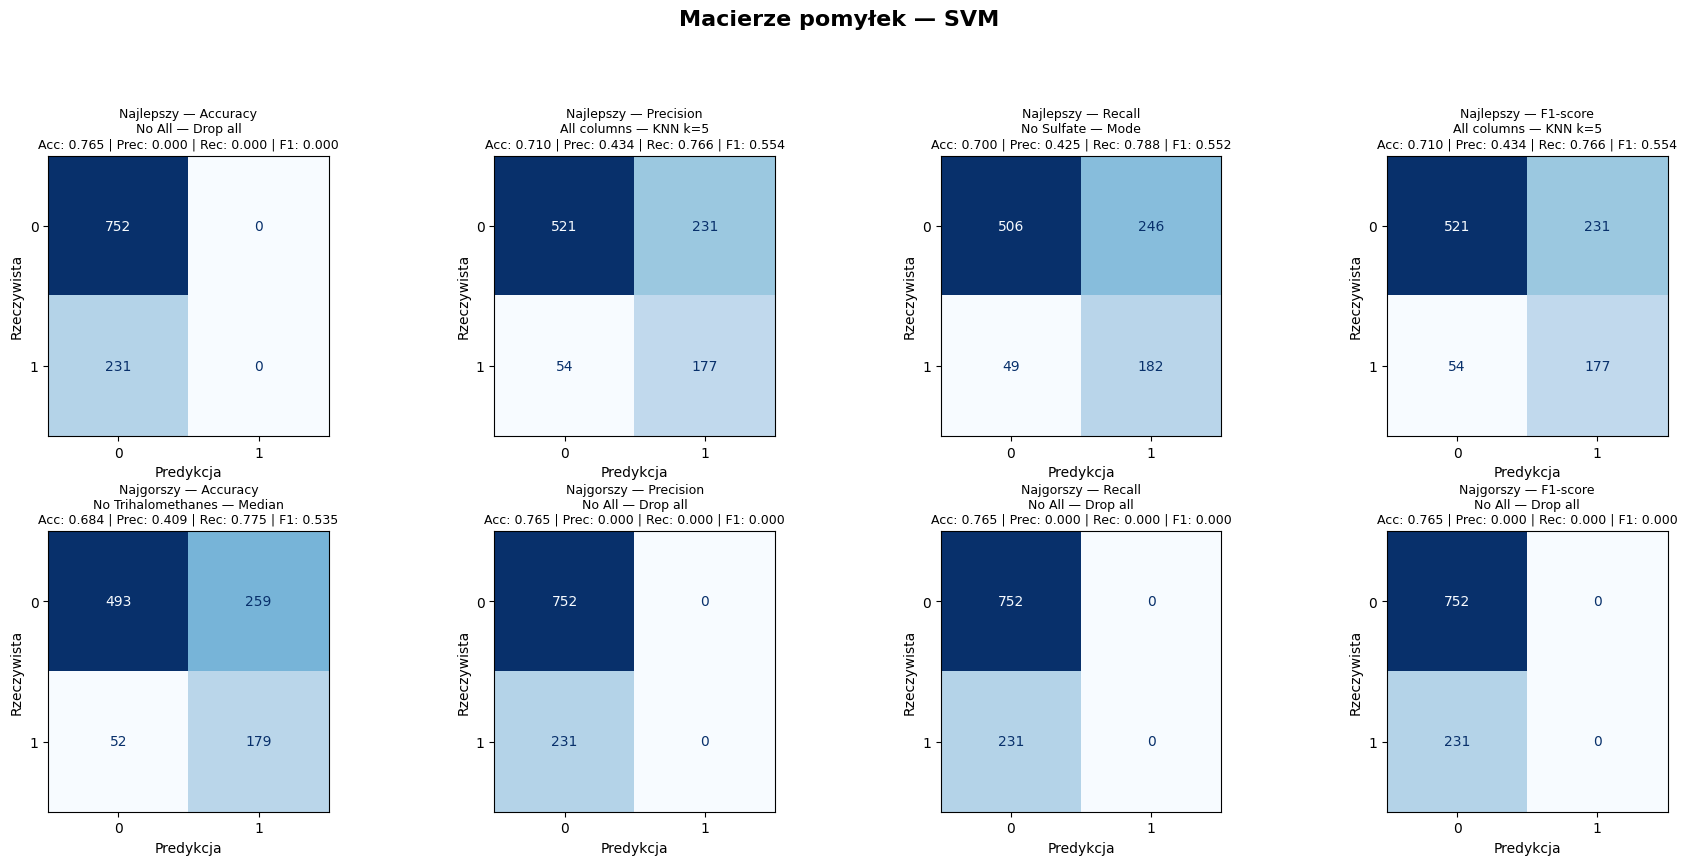

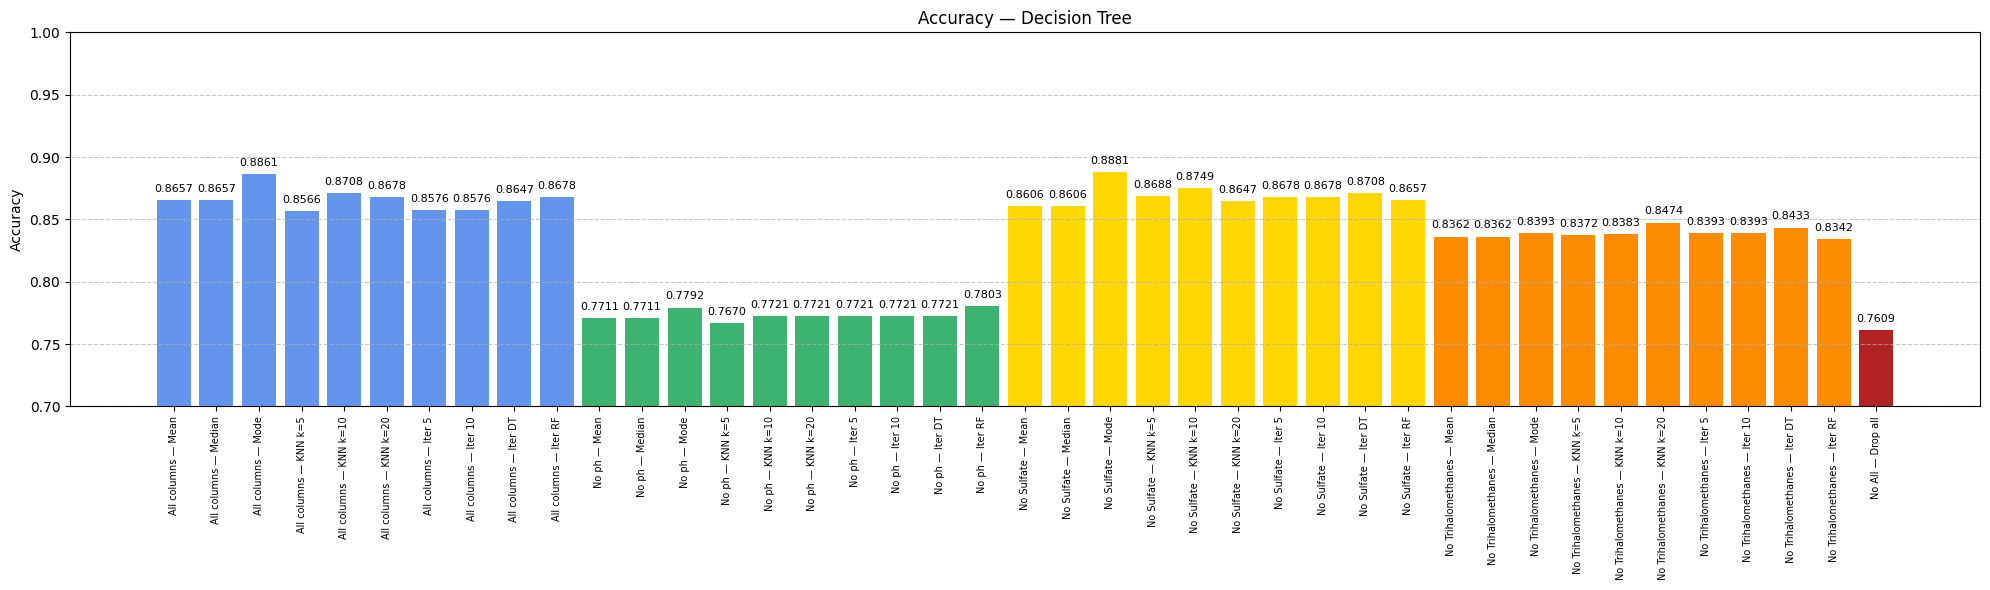

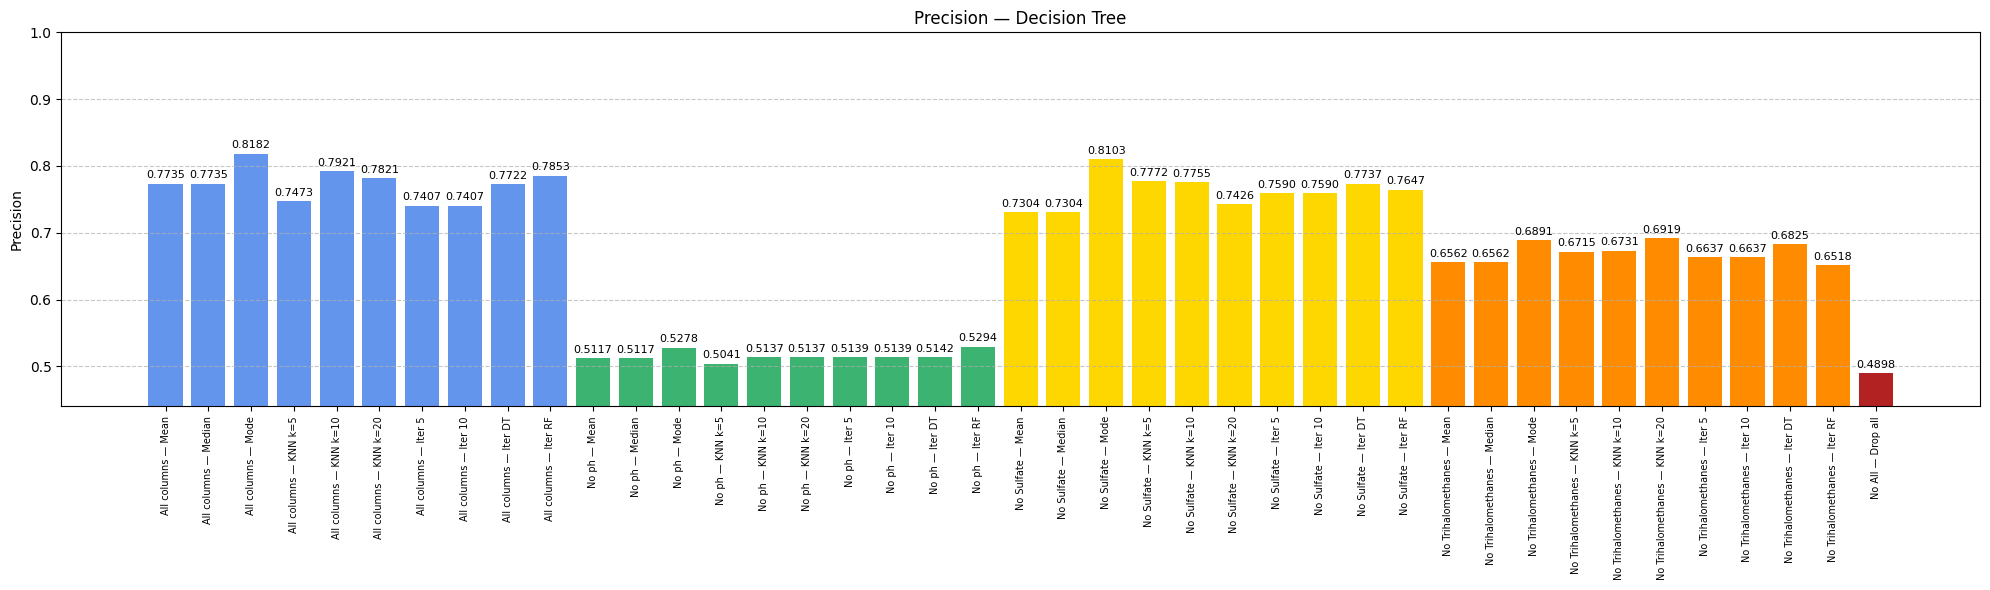

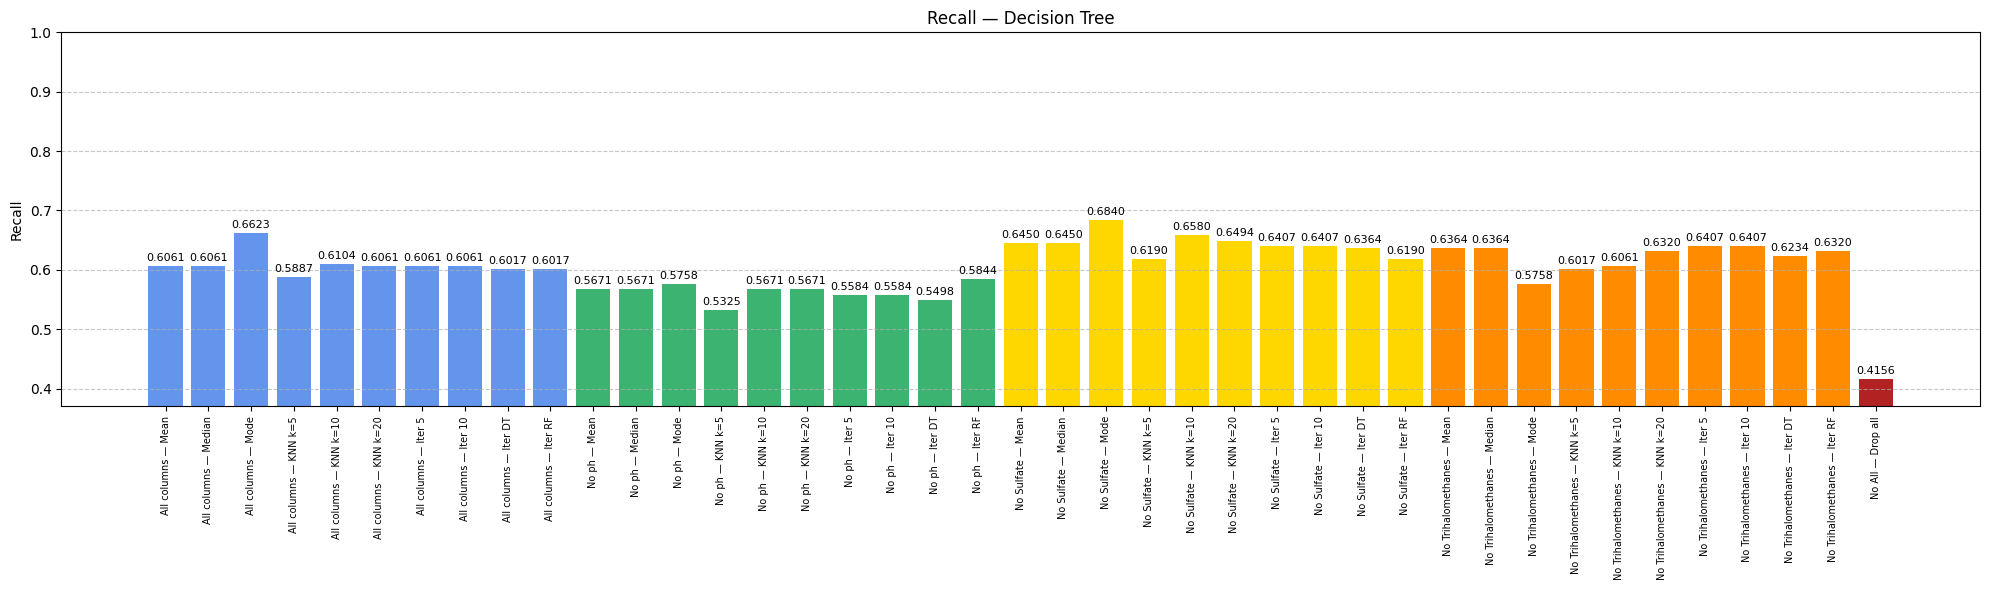

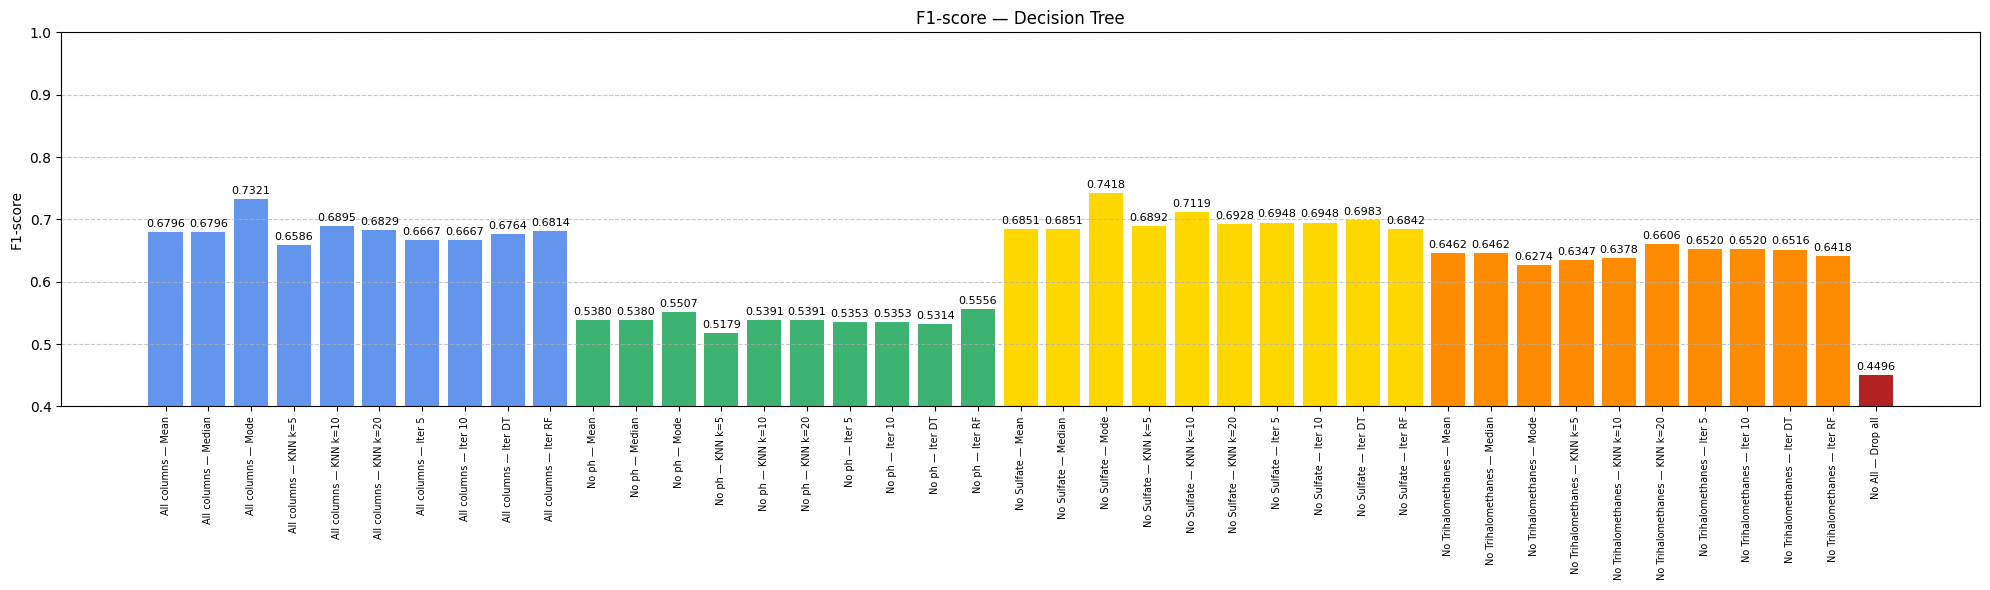


Macierze pomyłek — Decision Tree


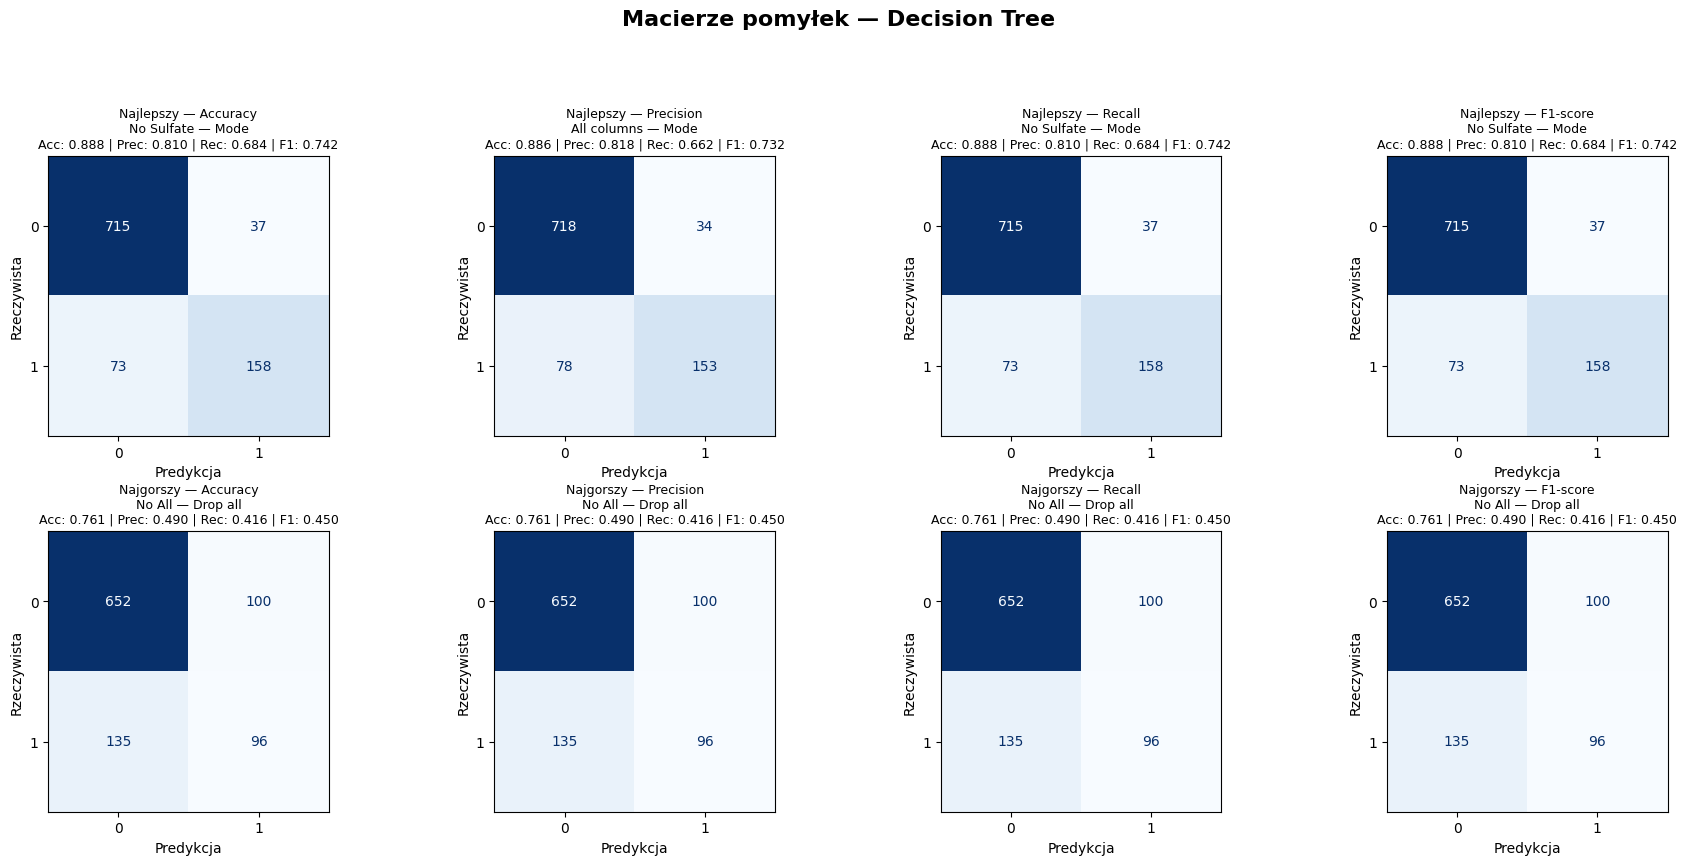

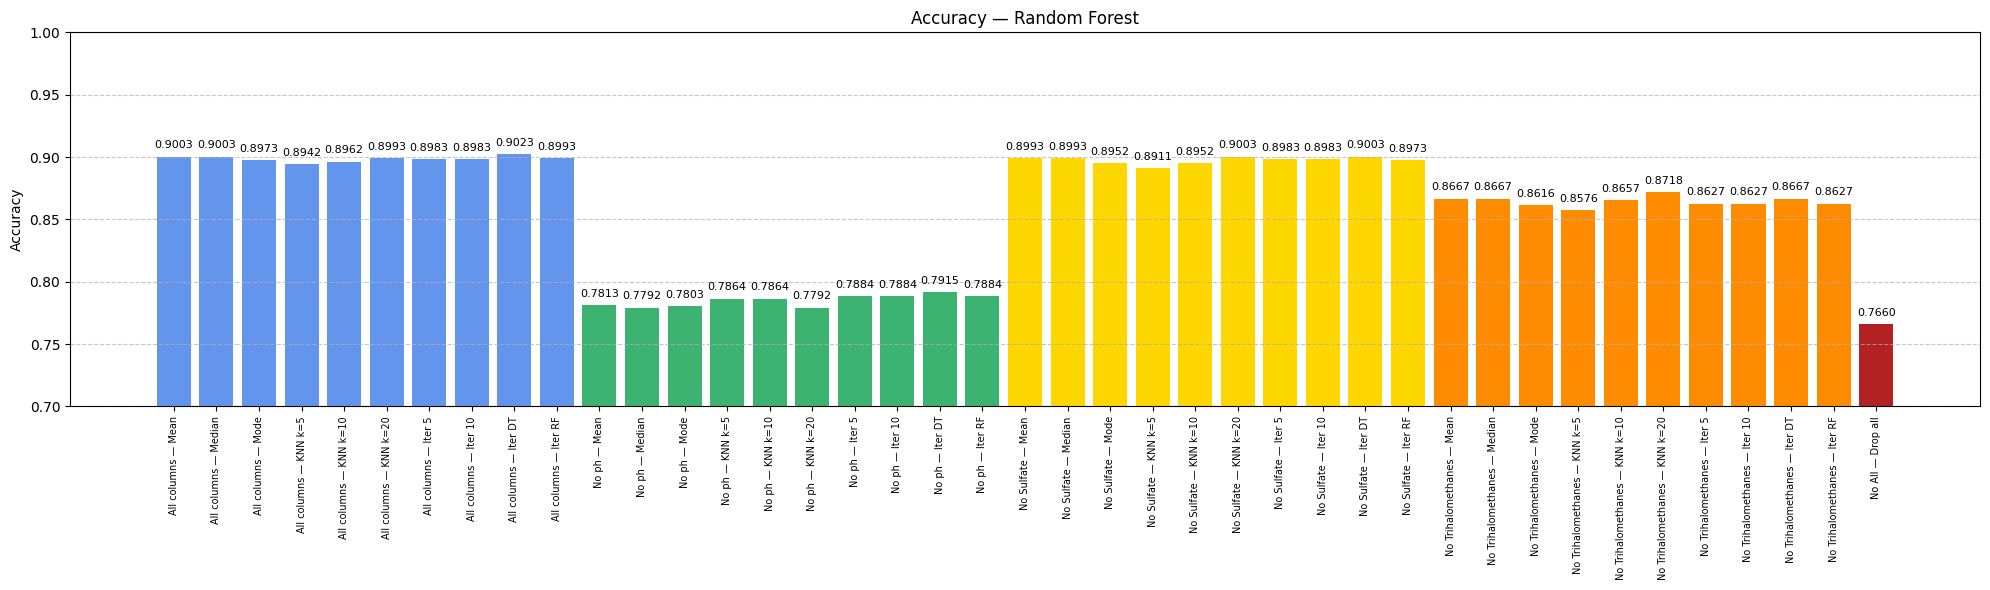

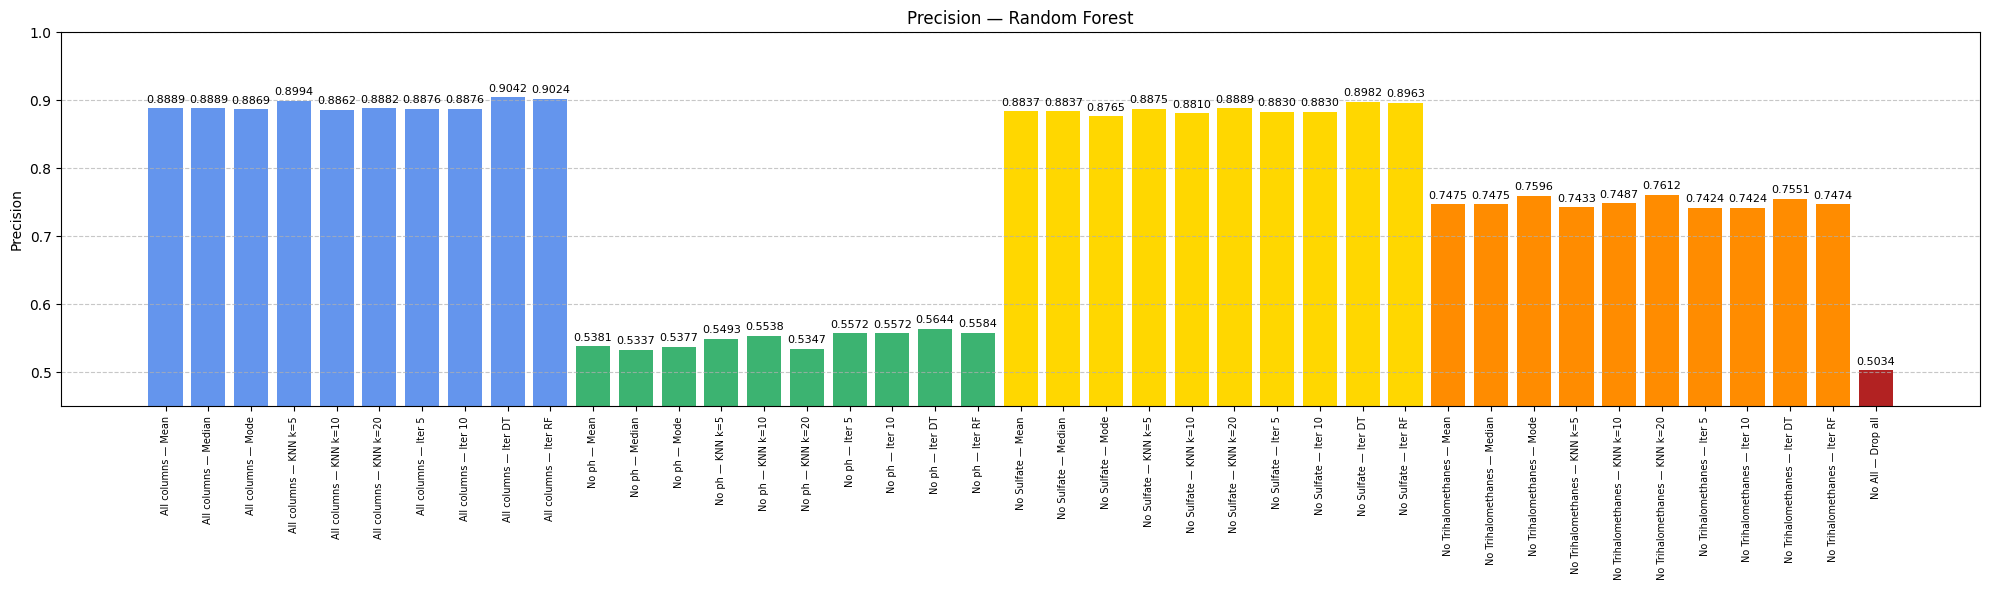

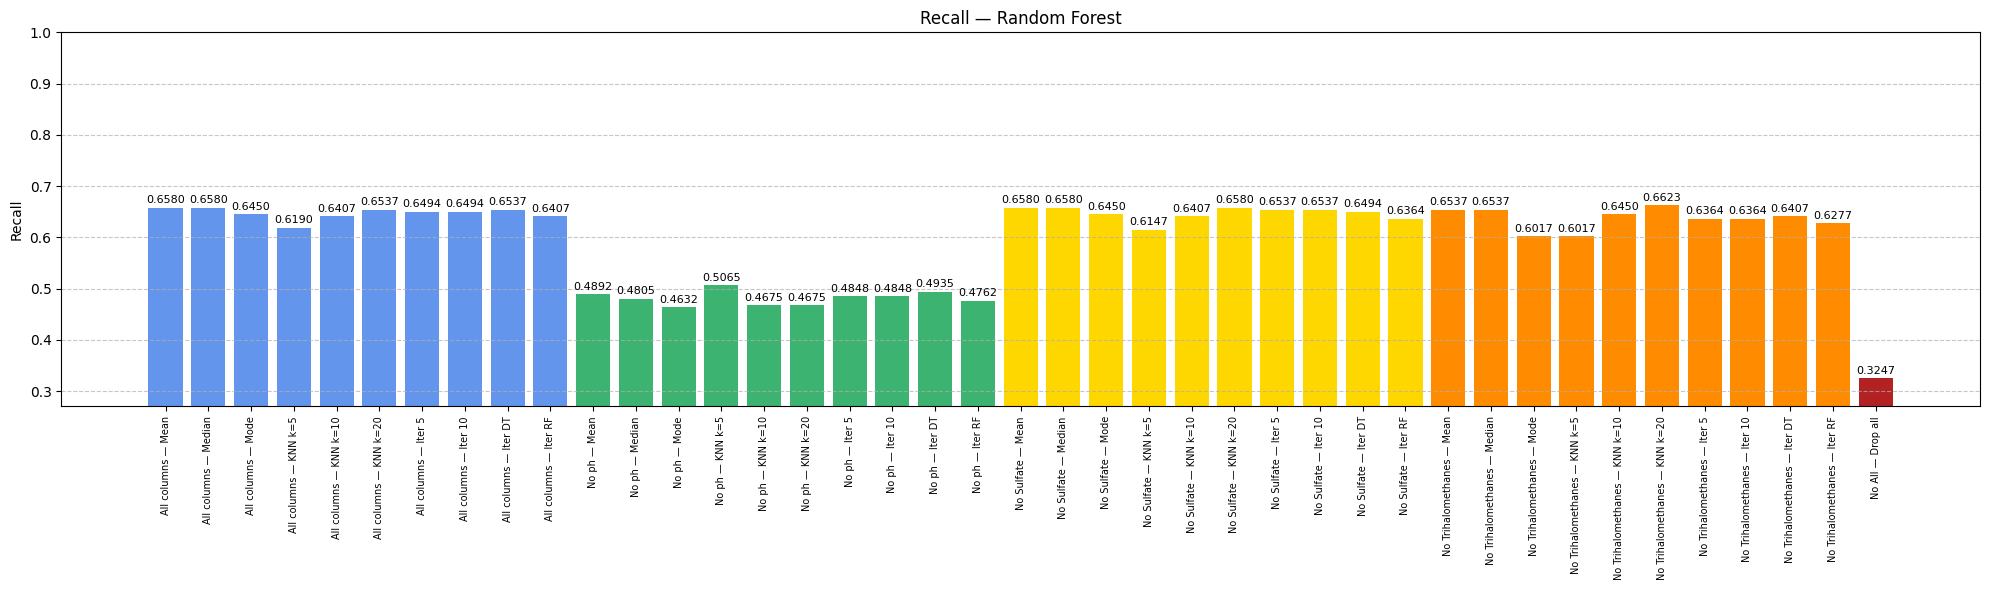

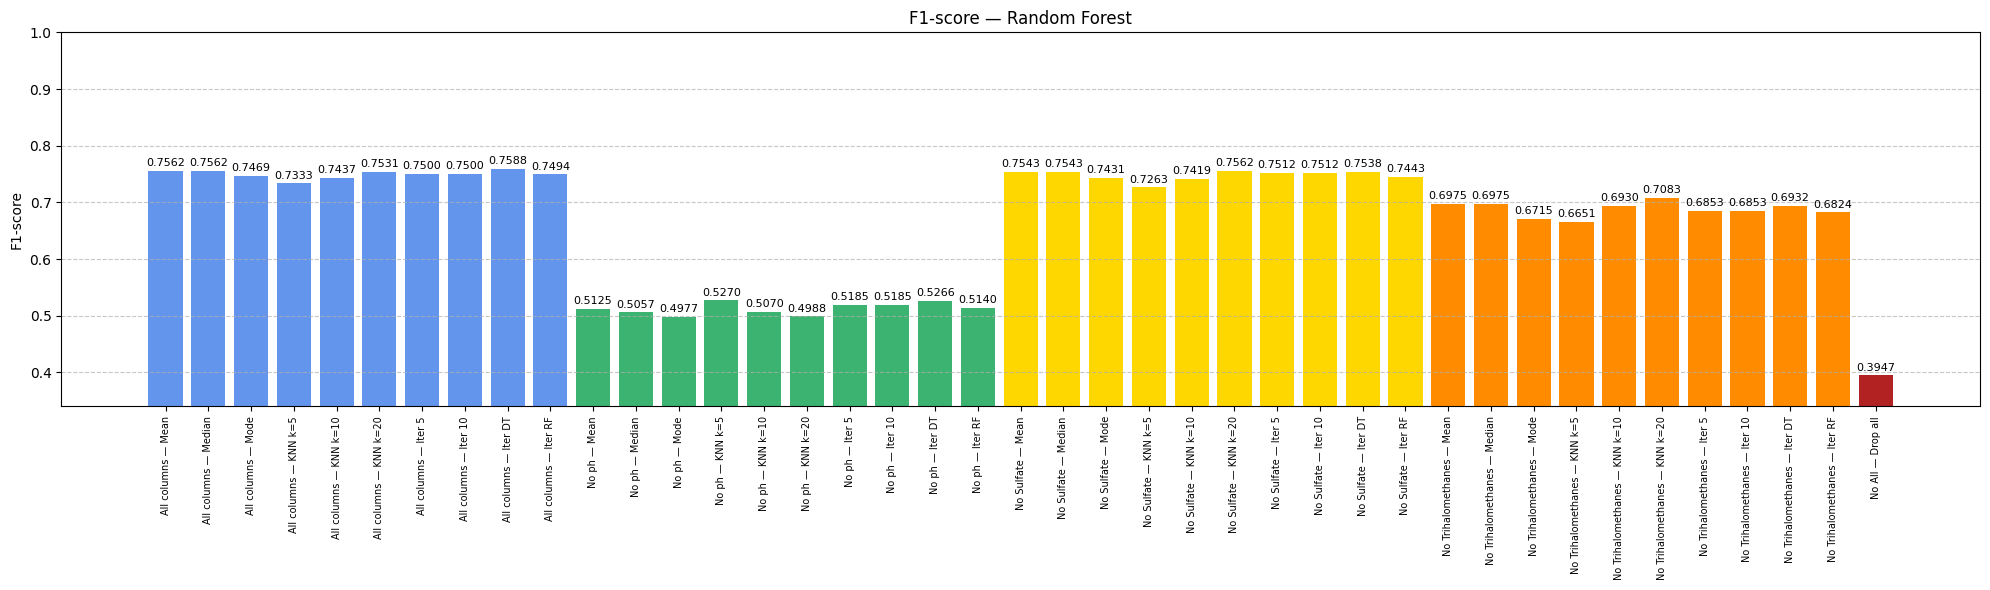


Macierze pomyłek — Random Forest


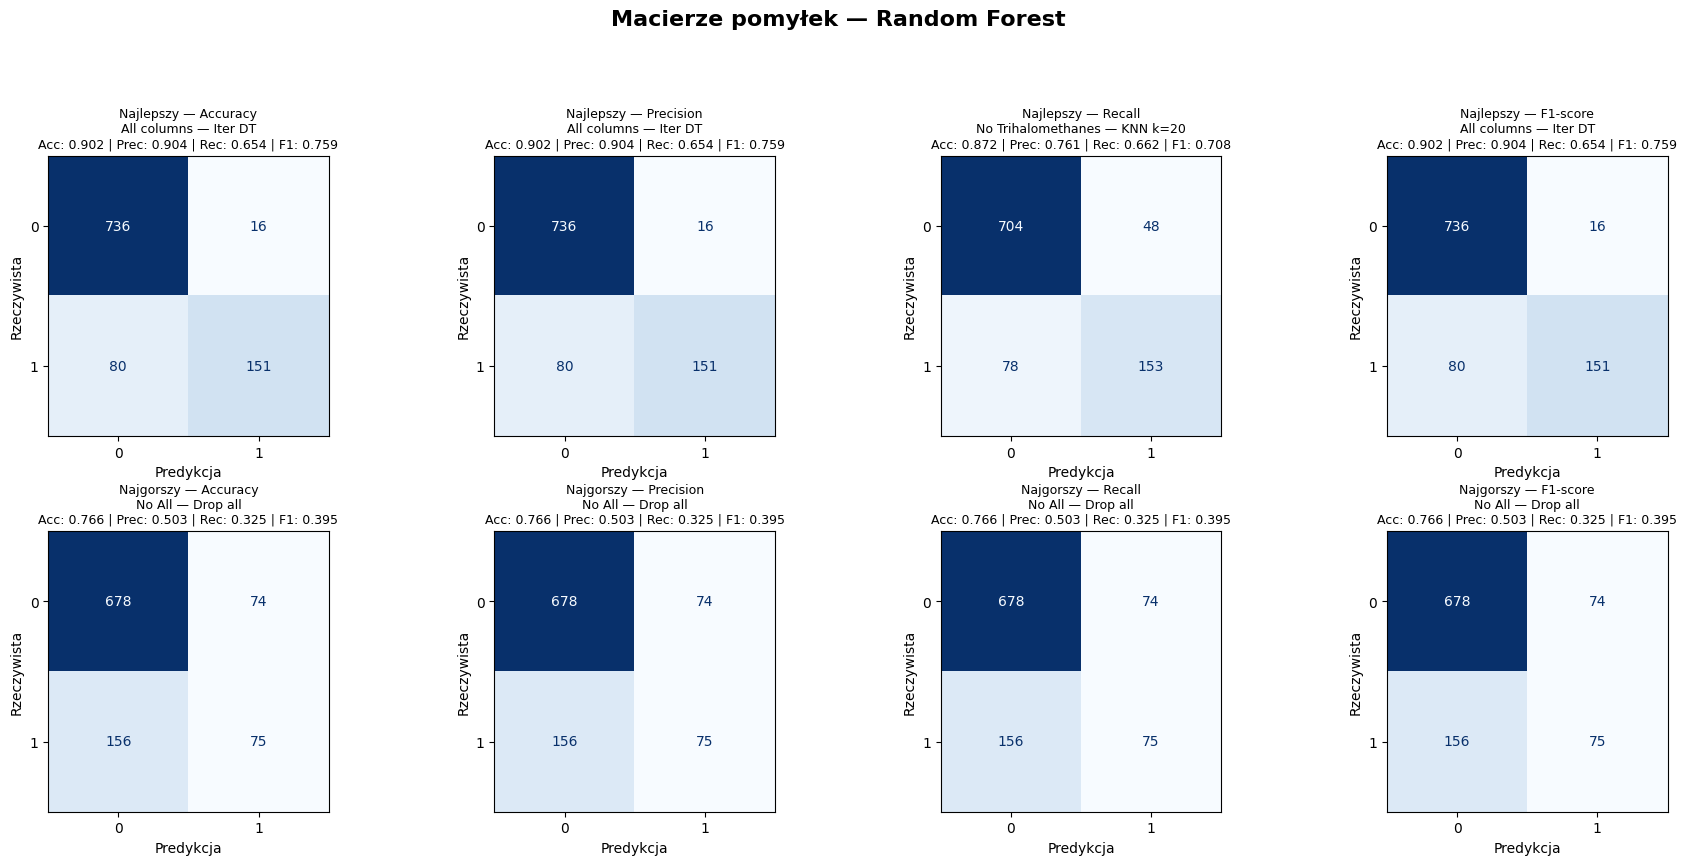

In [12]:
def split_data(df):
    X = df.iloc[:, :-1].values  
    y = df.iloc[:, -1].values   
    return train_test_split(X, y, test_size=0.3, random_state=0)

X_train_mean, X_test_mean, y_train_mean, y_test_mean = split_data(df_mean)
X_train_median, X_test_median, y_train_median, y_test_median = split_data(df_median)
X_train_mode, X_test_mode, y_train_mode, y_test_mode = split_data(df_mode)
X_train_knn_5, X_test_knn_5, y_train_knn_5, y_test_knn_5 = split_data(df_knn_5)
X_train_knn_10, X_test_knn_10, y_train_knn_10, y_test_knn_10 = split_data(df_knn_10)
X_train_knn_20, X_test_knn_20, y_train_knn_20, y_test_knn_20 = split_data(df_knn_20)
X_train_iter_5, X_test_iter_5, y_train_iter_5, y_test_iter_5 = split_data(df_iter_5)
X_train_iter_10, X_test_iter_10, y_train_iter_10, y_test_iter_10 = split_data(df_iter_10)
X_train_iter_dt, X_test_iter_dt, y_train_iter_dt, y_test_iter_dt = split_data(df_iter_dt)
X_train_iter_rf, X_test_iter_rf, y_train_iter_rf, y_test_iter_rf = split_data(df_iter_rf)

X_train_mean_no_ph, X_test_mean_no_ph, y_train_mean_no_ph, y_test_mean_no_ph = split_data(df_mean_no_ph)
X_train_median_no_ph, X_test_median_no_ph, y_train_median_no_ph, y_test_median_no_ph = split_data(df_median_no_ph)
X_train_mode_no_ph, X_test_mode_no_ph, y_train_mode_no_ph, y_test_mode_no_ph = split_data(df_mode_no_ph)
X_train_knn_5_no_ph, X_test_knn_5_no_ph, y_train_knn_5_no_ph, y_test_knn_5_no_ph = split_data(df_knn_5_no_ph)
X_train_knn_10_no_ph, X_test_knn_10_no_ph, y_train_knn_10_no_ph, y_test_knn_10_no_ph = split_data(df_knn_10_no_ph)
X_train_knn_20_no_ph, X_test_knn_20_no_ph, y_train_knn_20_no_ph, y_test_knn_20_no_ph = split_data(df_knn_20_no_ph)
X_train_iter_5_no_ph, X_test_iter_5_no_ph, y_train_iter_5_no_ph, y_test_iter_5_no_ph = split_data(df_iter_5_no_ph)
X_train_iter_10_no_ph, X_test_iter_10_no_ph, y_train_iter_10_no_ph, y_test_iter_10_no_ph = split_data(df_iter_10_no_ph)
X_train_iter_dt_no_ph, X_test_iter_dt_no_ph, y_train_iter_dt_no_ph, y_test_iter_dt_no_ph = split_data(df_iter_dt_no_ph)
X_train_iter_rf_no_ph, X_test_iter_rf_no_ph, y_train_iter_rf_no_ph, y_test_iter_rf_no_ph = split_data(df_iter_rf_no_ph)

X_train_mean_no_sulfate, X_test_mean_no_sulfate, y_train_mean_no_sulfate, y_test_mean_no_sulfate = split_data(df_mean_no_sulfate)
X_train_median_no_sulfate, X_test_median_no_sulfate, y_train_median_no_sulfate, y_test_median_no_sulfate = split_data(df_median_no_sulfate)
X_train_mode_no_sulfate, X_test_mode_no_sulfate, y_train_mode_no_sulfate, y_test_mode_no_sulfate = split_data(df_mode_no_sulfate)
X_train_knn_5_no_sulfate, X_test_knn_5_no_sulfate, y_train_knn_5_no_sulfate, y_test_knn_5_no_sulfate = split_data(df_knn_5_no_sulfate)
X_train_knn_10_no_sulfate, X_test_knn_10_no_sulfate, y_train_knn_10_no_sulfate, y_test_knn_10_no_sulfate = split_data(df_knn_10_no_sulfate)
X_train_knn_20_no_sulfate, X_test_knn_20_no_sulfate, y_train_knn_20_no_sulfate, y_test_knn_20_no_sulfate = split_data(df_knn_20_no_sulfate)
X_train_iter_5_no_sulfate, X_test_iter_5_no_sulfate, y_train_iter_5_no_sulfate, y_test_iter_5_no_sulfate = split_data(df_iter_5_no_sulfate)
X_train_iter_10_no_sulfate, X_test_iter_10_no_sulfate, y_train_iter_10_no_sulfate, y_test_iter_10_no_sulfate = split_data(df_iter_10_no_sulfate)
X_train_iter_dt_no_sulfate, X_test_iter_dt_no_sulfate, y_train_iter_dt_no_sulfate, y_test_iter_dt_no_sulfate = split_data(df_iter_dt_no_sulfate)
X_train_iter_rf_no_sulfate, X_test_iter_rf_no_sulfate, y_train_iter_rf_no_sulfate, y_test_iter_rf_no_sulfate = split_data(df_iter_rf_no_sulfate)

X_train_mean_no_trihalo, X_test_mean_no_trihalo, y_train_mean_no_trihalo, y_test_mean_no_trihalo = split_data(df_mean_no_trihalo)
X_train_median_no_trihalo, X_test_median_no_trihalo, y_train_median_no_trihalo, y_test_median_no_trihalo = split_data(df_median_no_trihalo)
X_train_mode_no_trihalo, X_test_mode_no_trihalo, y_train_mode_no_trihalo, y_test_mode_no_trihalo = split_data(df_mode_no_trihalo)
X_train_knn_5_no_trihalo, X_test_knn_5_no_trihalo, y_train_knn_5_no_trihalo, y_test_knn_5_no_trihalo = split_data(df_knn_5_no_trihalo)
X_train_knn_10_no_trihalo, X_test_knn_10_no_trihalo, y_train_knn_10_no_trihalo, y_test_knn_10_no_trihalo = split_data(df_knn_10_no_trihalo)
X_train_knn_20_no_trihalo, X_test_knn_20_no_trihalo, y_train_knn_20_no_trihalo, y_test_knn_20_no_trihalo = split_data(df_knn_20_no_trihalo)
X_train_iter_5_no_trihalo, X_test_iter_5_no_trihalo, y_train_iter_5_no_trihalo, y_test_iter_5_no_trihalo = split_data(df_iter_5_no_trihalo)
X_train_iter_10_no_trihalo, X_test_iter_10_no_trihalo, y_train_iter_10_no_trihalo, y_test_iter_10_no_trihalo = split_data(df_iter_10_no_trihalo)
X_train_iter_dt_no_trihalo, X_test_iter_dt_no_trihalo, y_train_iter_dt_no_trihalo, y_test_iter_dt_no_trihalo = split_data(df_iter_dt_no_trihalo)
X_train_iter_rf_no_trihalo, X_test_iter_rf_no_trihalo, y_train_iter_rf_no_trihalo, y_test_iter_rf_no_trihalo = split_data(df_iter_rf_no_trihalo)

X_train_no_all, X_test_no_all, y_train_no_all, y_test_no_all = split_data(df_no_all)

knn = KNeighborsClassifier(n_neighbors=7, weights="distance", metric="manhattan")
svm = SVC(kernel="rbf", C=10, gamma=0.1, class_weight='balanced', random_state=42)
dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, criterion='entropy', random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=3, max_features="sqrt", random_state=42)

def train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_metric = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1_metric

wszystkie_zbiory = [
    ("All columns", [
        ("Mean", X_train_mean, X_test_mean, y_train_mean, y_test_mean),
        ("Median", X_train_median, X_test_median, y_train_median, y_test_median),
        ("Mode", X_train_mode, X_test_mode, y_train_mode, y_test_mode),
        ("KNN k=5", X_train_knn_5, X_test_knn_5, y_train_knn_5, y_test_knn_5),
        ("KNN k=10", X_train_knn_10, X_test_knn_10, y_train_knn_10, y_test_knn_10),
        ("KNN k=20", X_train_knn_20, X_test_knn_20, y_train_knn_20, y_test_knn_20),
        ("Iter 5", X_train_iter_5, X_test_iter_5, y_train_iter_5, y_test_iter_5),
        ("Iter 10", X_train_iter_10, X_test_iter_10, y_train_iter_10, y_test_iter_10),
        ("Iter DT", X_train_iter_dt, X_test_iter_dt, y_train_iter_dt, y_test_iter_dt),
        ("Iter RF", X_train_iter_rf, X_test_iter_rf, y_train_iter_rf, y_test_iter_rf)
    ]),
    ("No ph", [
        ("Mean", X_train_mean_no_ph, X_test_mean_no_ph, y_train_mean_no_ph, y_test_mean_no_ph),
        ("Median", X_train_median_no_ph, X_test_median_no_ph, y_train_median_no_ph, y_test_median_no_ph),
        ("Mode", X_train_mode_no_ph, X_test_mode_no_ph, y_train_mode_no_ph, y_test_mode_no_ph),
        ("KNN k=5", X_train_knn_5_no_ph, X_test_knn_5_no_ph, y_train_knn_5_no_ph, y_test_knn_5_no_ph),
        ("KNN k=10", X_train_knn_10_no_ph, X_test_knn_10_no_ph, y_train_knn_10_no_ph, y_test_knn_10_no_ph),
        ("KNN k=20", X_train_knn_20_no_ph, X_test_knn_20_no_ph, y_train_knn_20_no_ph, y_test_knn_20_no_ph),
        ("Iter 5", X_train_iter_5_no_ph, X_test_iter_5_no_ph, y_train_iter_5_no_ph, y_test_iter_5_no_ph),
        ("Iter 10", X_train_iter_10_no_ph, X_test_iter_10_no_ph, y_train_iter_10_no_ph, y_test_iter_10_no_ph),
        ("Iter DT", X_train_iter_dt_no_ph, X_test_iter_dt_no_ph, y_train_iter_dt_no_ph, y_test_iter_dt_no_ph),
        ("Iter RF", X_train_iter_rf_no_ph, X_test_iter_rf_no_ph, y_train_iter_rf_no_ph, y_test_iter_rf_no_ph)
    ]),
    ("No Sulfate", [
        ("Mean", X_train_mean_no_sulfate, X_test_mean_no_sulfate, y_train_mean_no_sulfate, y_test_mean_no_sulfate),
        ("Median", X_train_median_no_sulfate, X_test_median_no_sulfate, y_train_median_no_sulfate, y_test_median_no_sulfate),
        ("Mode", X_train_mode_no_sulfate, X_test_mode_no_sulfate, y_train_mode_no_sulfate, y_test_mode_no_sulfate),
        ("KNN k=5", X_train_knn_5_no_sulfate, X_test_knn_5_no_sulfate, y_train_knn_5_no_sulfate, y_test_knn_5_no_sulfate),
        ("KNN k=10", X_train_knn_10_no_sulfate, X_test_knn_10_no_sulfate, y_train_knn_10_no_sulfate, y_test_knn_10_no_sulfate),
        ("KNN k=20", X_train_knn_20_no_sulfate, X_test_knn_20_no_sulfate, y_train_knn_20_no_sulfate, y_test_knn_20_no_sulfate),
        ("Iter 5", X_train_iter_5_no_sulfate, X_test_iter_5_no_sulfate, y_train_iter_5_no_sulfate, y_test_iter_5_no_sulfate),
        ("Iter 10", X_train_iter_10_no_sulfate, X_test_iter_10_no_sulfate, y_train_iter_10_no_sulfate, y_test_iter_10_no_sulfate),
        ("Iter DT", X_train_iter_dt_no_sulfate, X_test_iter_dt_no_sulfate, y_train_iter_dt_no_sulfate, y_test_iter_dt_no_sulfate),
        ("Iter RF", X_train_iter_rf_no_sulfate, X_test_iter_rf_no_sulfate, y_train_iter_rf_no_sulfate, y_test_iter_rf_no_sulfate)
    ]),
    ("No Trihalomethanes", [
        ("Mean", X_train_mean_no_trihalo, X_test_mean_no_trihalo, y_train_mean_no_trihalo, y_test_mean_no_trihalo),
        ("Median", X_train_median_no_trihalo, X_test_median_no_trihalo, y_train_median_no_trihalo, y_test_median_no_trihalo),
        ("Mode", X_train_mode_no_trihalo, X_test_mode_no_trihalo, y_train_mode_no_trihalo, y_test_mode_no_trihalo),
        ("KNN k=5", X_train_knn_5_no_trihalo, X_test_knn_5_no_trihalo, y_train_knn_5_no_trihalo, y_test_knn_5_no_trihalo),
        ("KNN k=10", X_train_knn_10_no_trihalo, X_test_knn_10_no_trihalo, y_train_knn_10_no_trihalo, y_test_knn_10_no_trihalo),
        ("KNN k=20", X_train_knn_20_no_trihalo, X_test_knn_20_no_trihalo, y_train_knn_20_no_trihalo, y_test_knn_20_no_trihalo),
        ("Iter 5", X_train_iter_5_no_trihalo, X_test_iter_5_no_trihalo, y_train_iter_5_no_trihalo, y_test_iter_5_no_trihalo),
        ("Iter 10", X_train_iter_10_no_trihalo, X_test_iter_10_no_trihalo, y_train_iter_10_no_trihalo, y_test_iter_10_no_trihalo),
        ("Iter DT", X_train_iter_dt_no_trihalo, X_test_iter_dt_no_trihalo, y_train_iter_dt_no_trihalo, y_test_iter_dt_no_trihalo),
        ("Iter RF", X_train_iter_rf_no_trihalo, X_test_iter_rf_no_trihalo, y_train_iter_rf_no_trihalo, y_test_iter_rf_no_trihalo)
    ]),
    ("No All", [
        ("Drop all", X_train_no_all, X_test_no_all, y_train_no_all, y_test_no_all)
    ])
]

modele = {
    "KNN": knn,
    "SVM": svm,
    "Decision Tree": dt,
    "Random Forest": rf
}

zbior_kolory = {
    "All columns": "cornflowerblue",
    "No ph": "mediumseagreen",
    "No Sulfate": "gold",
    "No Trihalomethanes": "darkorange",
    "No All": "firebrick"
}
# Przechowywanie wyników + info o typie zbioru
results = {
    model_name: {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1-score": [],
        "Labels": [],
        "Colors": []
    } for model_name in modele.keys()
}

# Gromadzenie danych
for zbior_nazwa, metody in wszystkie_zbiory:
    color = zbior_kolory.get(zbior_nazwa, "gray")
    
    for metoda_nazwa, X_train, X_test, y_train, y_test in metody:
        label = f"{zbior_nazwa} — {metoda_nazwa}"

        for model_name, model in modele.items():
            acc, prec, rec, f1 = train(model, X_train, X_test, y_train, y_test)
            results[model_name]["Accuracy"].append(acc)
            results[model_name]["Precision"].append(prec)
            results[model_name]["Recall"].append(rec)
            results[model_name]["F1-score"].append(f1)
            results[model_name]["Labels"].append(label)
            results[model_name]["Colors"].append(color)

global_vmax = 1000

for model_name, metrics_dict in results.items():
    for metric_name in ["Accuracy", "Precision", "Recall", "F1-score"]:
        labels = metrics_dict["Labels"]
        values = metrics_dict[metric_name]
        colors = metrics_dict["Colors"]

        min_val = min(values)
        start_ylim = 0.7 if min_val > 0.7 else round(min_val - 0.05, 2)
        plt.figure(figsize=(20, 6))
        bars = plt.bar(labels, values, color=colors)

        for bar, value, label in zip(bars, values, labels):
            height = bar.get_height()
            if height < start_ylim:
                plt.text(bar.get_x() + bar.get_width()/2, start_ylim + 0.01,
                         f"{value:.4f}\n({label})",
                         ha='center', va='bottom', rotation=90, fontsize=8, color='red')
                bar.set_height(start_ylim)
            else:
                plt.text(bar.get_x() + bar.get_width()/2, height + 0.005,
                         f"{value:.4f}", ha='center', va='bottom', fontsize=8)

        plt.ylim(start_ylim, 1.0)
        plt.xticks(rotation=90, fontsize=7)
        plt.title(f"{metric_name} — {model_name}")
        plt.ylabel(metric_name)
        plt.grid(axis="y", linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    # MACIERZE POMYŁEK — SIATKA 2x4
    print(f"\nMacierze pomyłek — {model_name}")

    fig, axes = plt.subplots(2, 4, figsize=(18, 9))
    fig.suptitle(f'Macierze pomyłek — {model_name}', fontsize=16, fontweight='bold')

    for row_idx, mode in enumerate(["Najlepszy", "Najgorszy"]):
        for col_idx, metric_name in enumerate(["Accuracy", "Precision", "Recall", "F1-score"]):
            idx = np.argmax(results[model_name][metric_name]) if mode == "Najlepszy" else np.argmin(results[model_name][metric_name])

            label = results[model_name]["Labels"][idx]
            zbior_name, imputacja = label.split(" — ")
            acc = results[model_name]["Accuracy"][idx]
            prec = results[model_name]["Precision"][idx]
            rec = results[model_name]["Recall"][idx]
            f1 = results[model_name]["F1-score"][idx]

            # Znajdź dane do predykcji
            for zbior_label, metody in wszystkie_zbiory:
                if zbior_label == zbior_name:
                    for metoda_label, X_train, X_test, y_train, y_test in metody:
                        if metoda_label == imputacja:
                            model = modele[model_name]
                            model.fit(X_train, y_train)
                            y_pred = model.predict(X_test)
                            cm = confusion_matrix(y_test, y_pred)
                            ax = axes[row_idx, col_idx]
                            im = ax.imshow(cm, interpolation='nearest', cmap='Blues', vmin=0, vmax=global_vmax)
                            disp = ConfusionMatrixDisplay(cm)
                            disp.plot(ax=ax, cmap="Blues", values_format='d', colorbar=False)

                            ax.set_title(
                                f"{mode} — {metric_name}\n{label}\n"
                                f"Acc: {acc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f}",
                                fontsize=9
                            )
                            ax.set_xlabel("Predykcja")
                            ax.set_ylabel("Rzeczywista")
                            break

    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.show()


Top 25 modeli wg F1-score:

            Model                          Zbiór  F1-score
0   Random Forest          All columns — Iter DT  0.758794
1   Random Forest           All columns — Median  0.756219
2   Random Forest          No Sulfate — KNN k=20  0.756219
3   Random Forest             All columns — Mean  0.756219
4   Random Forest            No Sulfate — Median  0.754342
5   Random Forest              No Sulfate — Mean  0.754342
6   Random Forest           No Sulfate — Iter DT  0.753769
7   Random Forest         All columns — KNN k=20  0.753117
8   Random Forest            No Sulfate — Iter 5  0.751244
9   Random Forest           No Sulfate — Iter 10  0.751244
10  Random Forest          All columns — Iter 10  0.750000
11  Random Forest           All columns — Iter 5  0.750000
12  Random Forest          All columns — Iter RF  0.749367
13  Random Forest             All columns — Mode  0.746867
14  Random Forest           No Sulfate — Iter RF  0.744304
15  Random Forest         Al

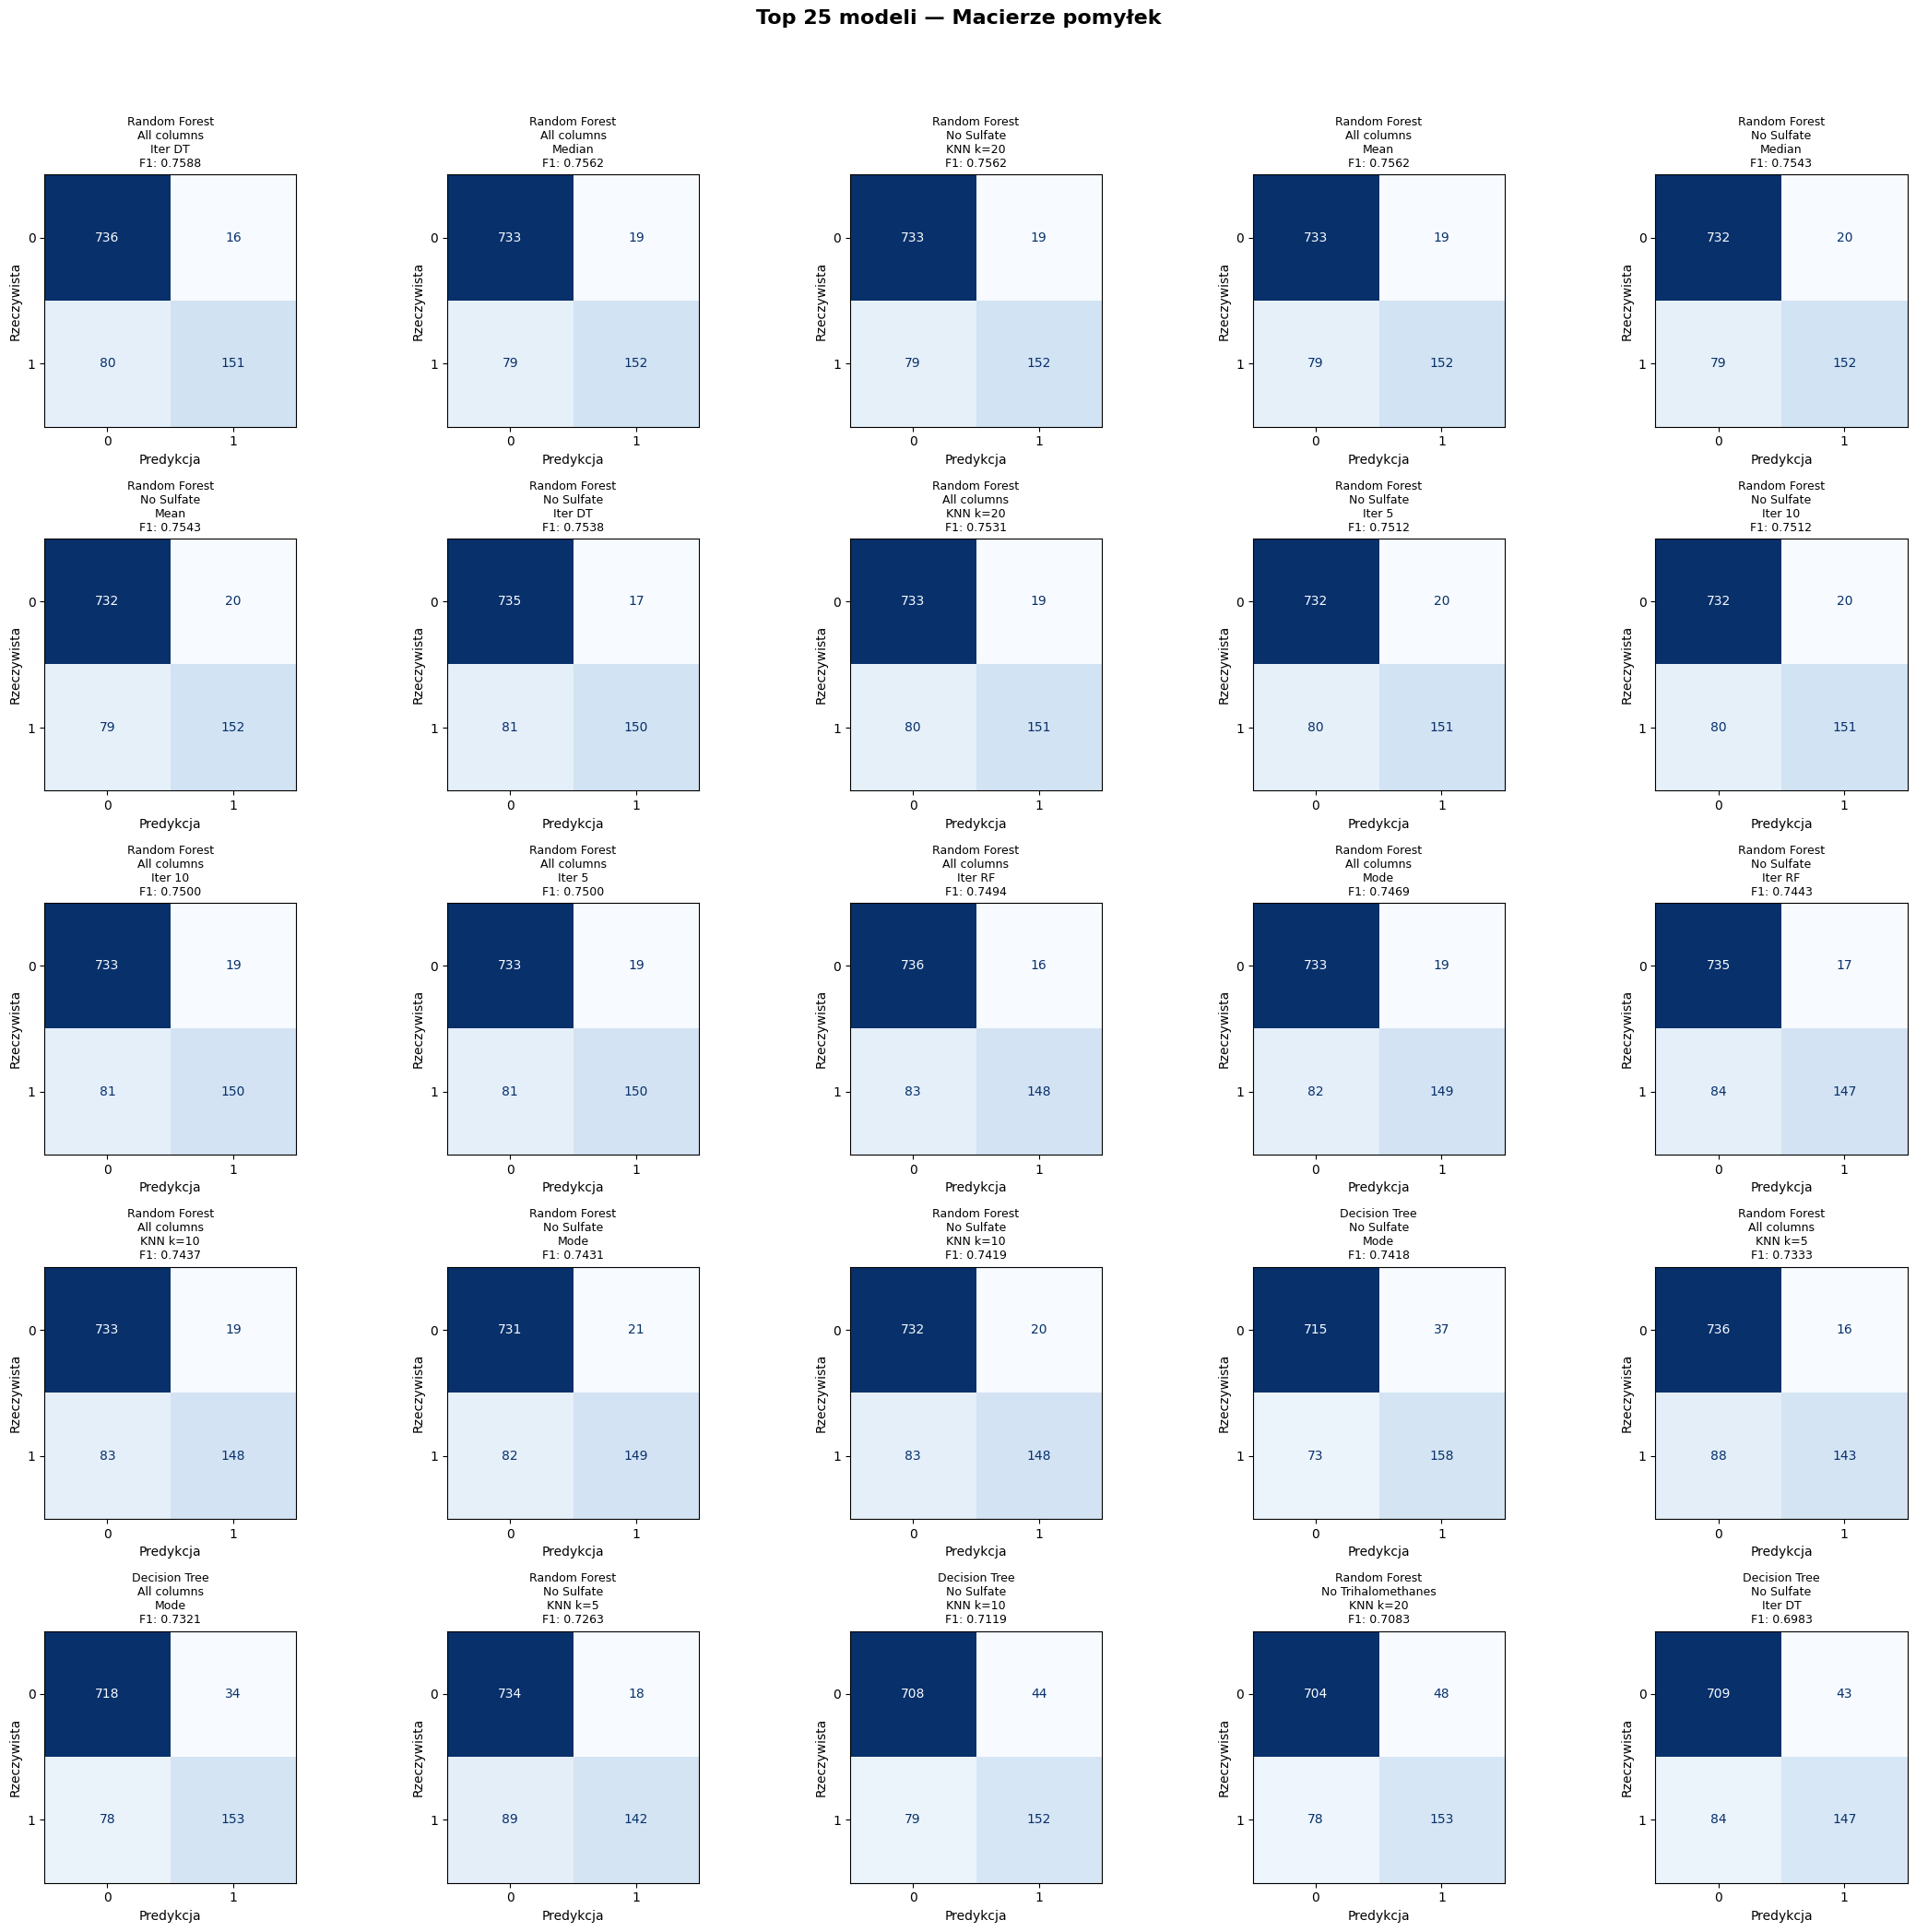

In [13]:
records = []
macierze = []
for model_name in results:
    for i in range(len(results[model_name]["Labels"])):
        records.append({
            "Model": model_name,
            "Zbiór": results[model_name]["Labels"][i],
            "Accuracy": results[model_name]["Accuracy"][i],
            "Precision": results[model_name]["Precision"][i],
            "Recall": results[model_name]["Recall"][i],
            "F1-score": results[model_name]["F1-score"][i],
            "Color": results[model_name]["Colors"][i]
        })

df_results = pd.DataFrame(records)
df_top25 = df_results.sort_values(by="F1-score", ascending=False).head(25).reset_index(drop=True)

# 2. Wyświetlenie top 25
print("Top 25 modeli wg F1-score:\n")
print(df_top25[["Model", "Zbiór", "F1-score"]])

# 3. Macierze pomyłek dla top 10
fig, axes = plt.subplots(5, 5, figsize=(22, 22))
fig.suptitle("Top 25 modeli — Macierze pomyłek", fontsize=16, fontweight="bold")

for idx, row in df_top25.iterrows():
    model_name = row["Model"]
    zbior_label, imputacja_label = row["Zbiór"].split(" — ")

    for zbior_nazwa, metody in wszystkie_zbiory:
        if zbior_nazwa == zbior_label:
            for metoda_nazwa, X_train, X_test, y_train, y_test in metody:
                if metoda_nazwa == imputacja_label:
                    model = modele[model_name]
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    cm = confusion_matrix(y_test, y_pred)

                    ax = axes[idx // 5, idx % 5]

                    # ustawienie "tła" z odpowiednim vmax
                    im = ax.imshow(cm, interpolation='nearest', cmap='Blues', vmin=0, vmax=global_vmax)
                    
                    # wywołanie disp.plot(), które użyje już istniejącego obrazu
                    disp = ConfusionMatrixDisplay(cm)
                    disp.plot(ax=ax, cmap="Blues", values_format='d', colorbar=False)

                    ax.set_title(
                        f"{model_name}\n{zbior_label}\n{imputacja_label}\nF1: {row['F1-score']:.4f}",
                        fontsize=9
                    )
                    ax.set_xlabel("Predykcja")
                    ax.set_ylabel("Rzeczywista")
                    break

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Bottom 25 modeli wg F1-score:

            Model                      Zbiór  F1-score
0             SVM          No All — Drop all  0.000000
1             KNN          No All — Drop all  0.305556
2   Random Forest          No All — Drop all  0.394737
3             KNN               No ph — Mode  0.425974
4             KNN            No ph — Iter RF  0.442786
5             KNN           No ph — KNN k=10  0.445570
6   Decision Tree          No All — Drop all  0.449649
7             KNN            No ph — Iter 10  0.460759
8             KNN             No ph — Iter 5  0.460759
9             KNN            No ph — Iter DT  0.461153
10            KNN           No ph — KNN k=20  0.466165
11            KNN  No Trihalomethanes — Mode  0.479012
12            KNN            No ph — KNN k=5  0.485000
13            KNN             No ph — Median  0.486216
14            KNN               No ph — Mean  0.486216
15  Random Forest               No ph — Mode  0.497674
16  Random Forest           No ph 

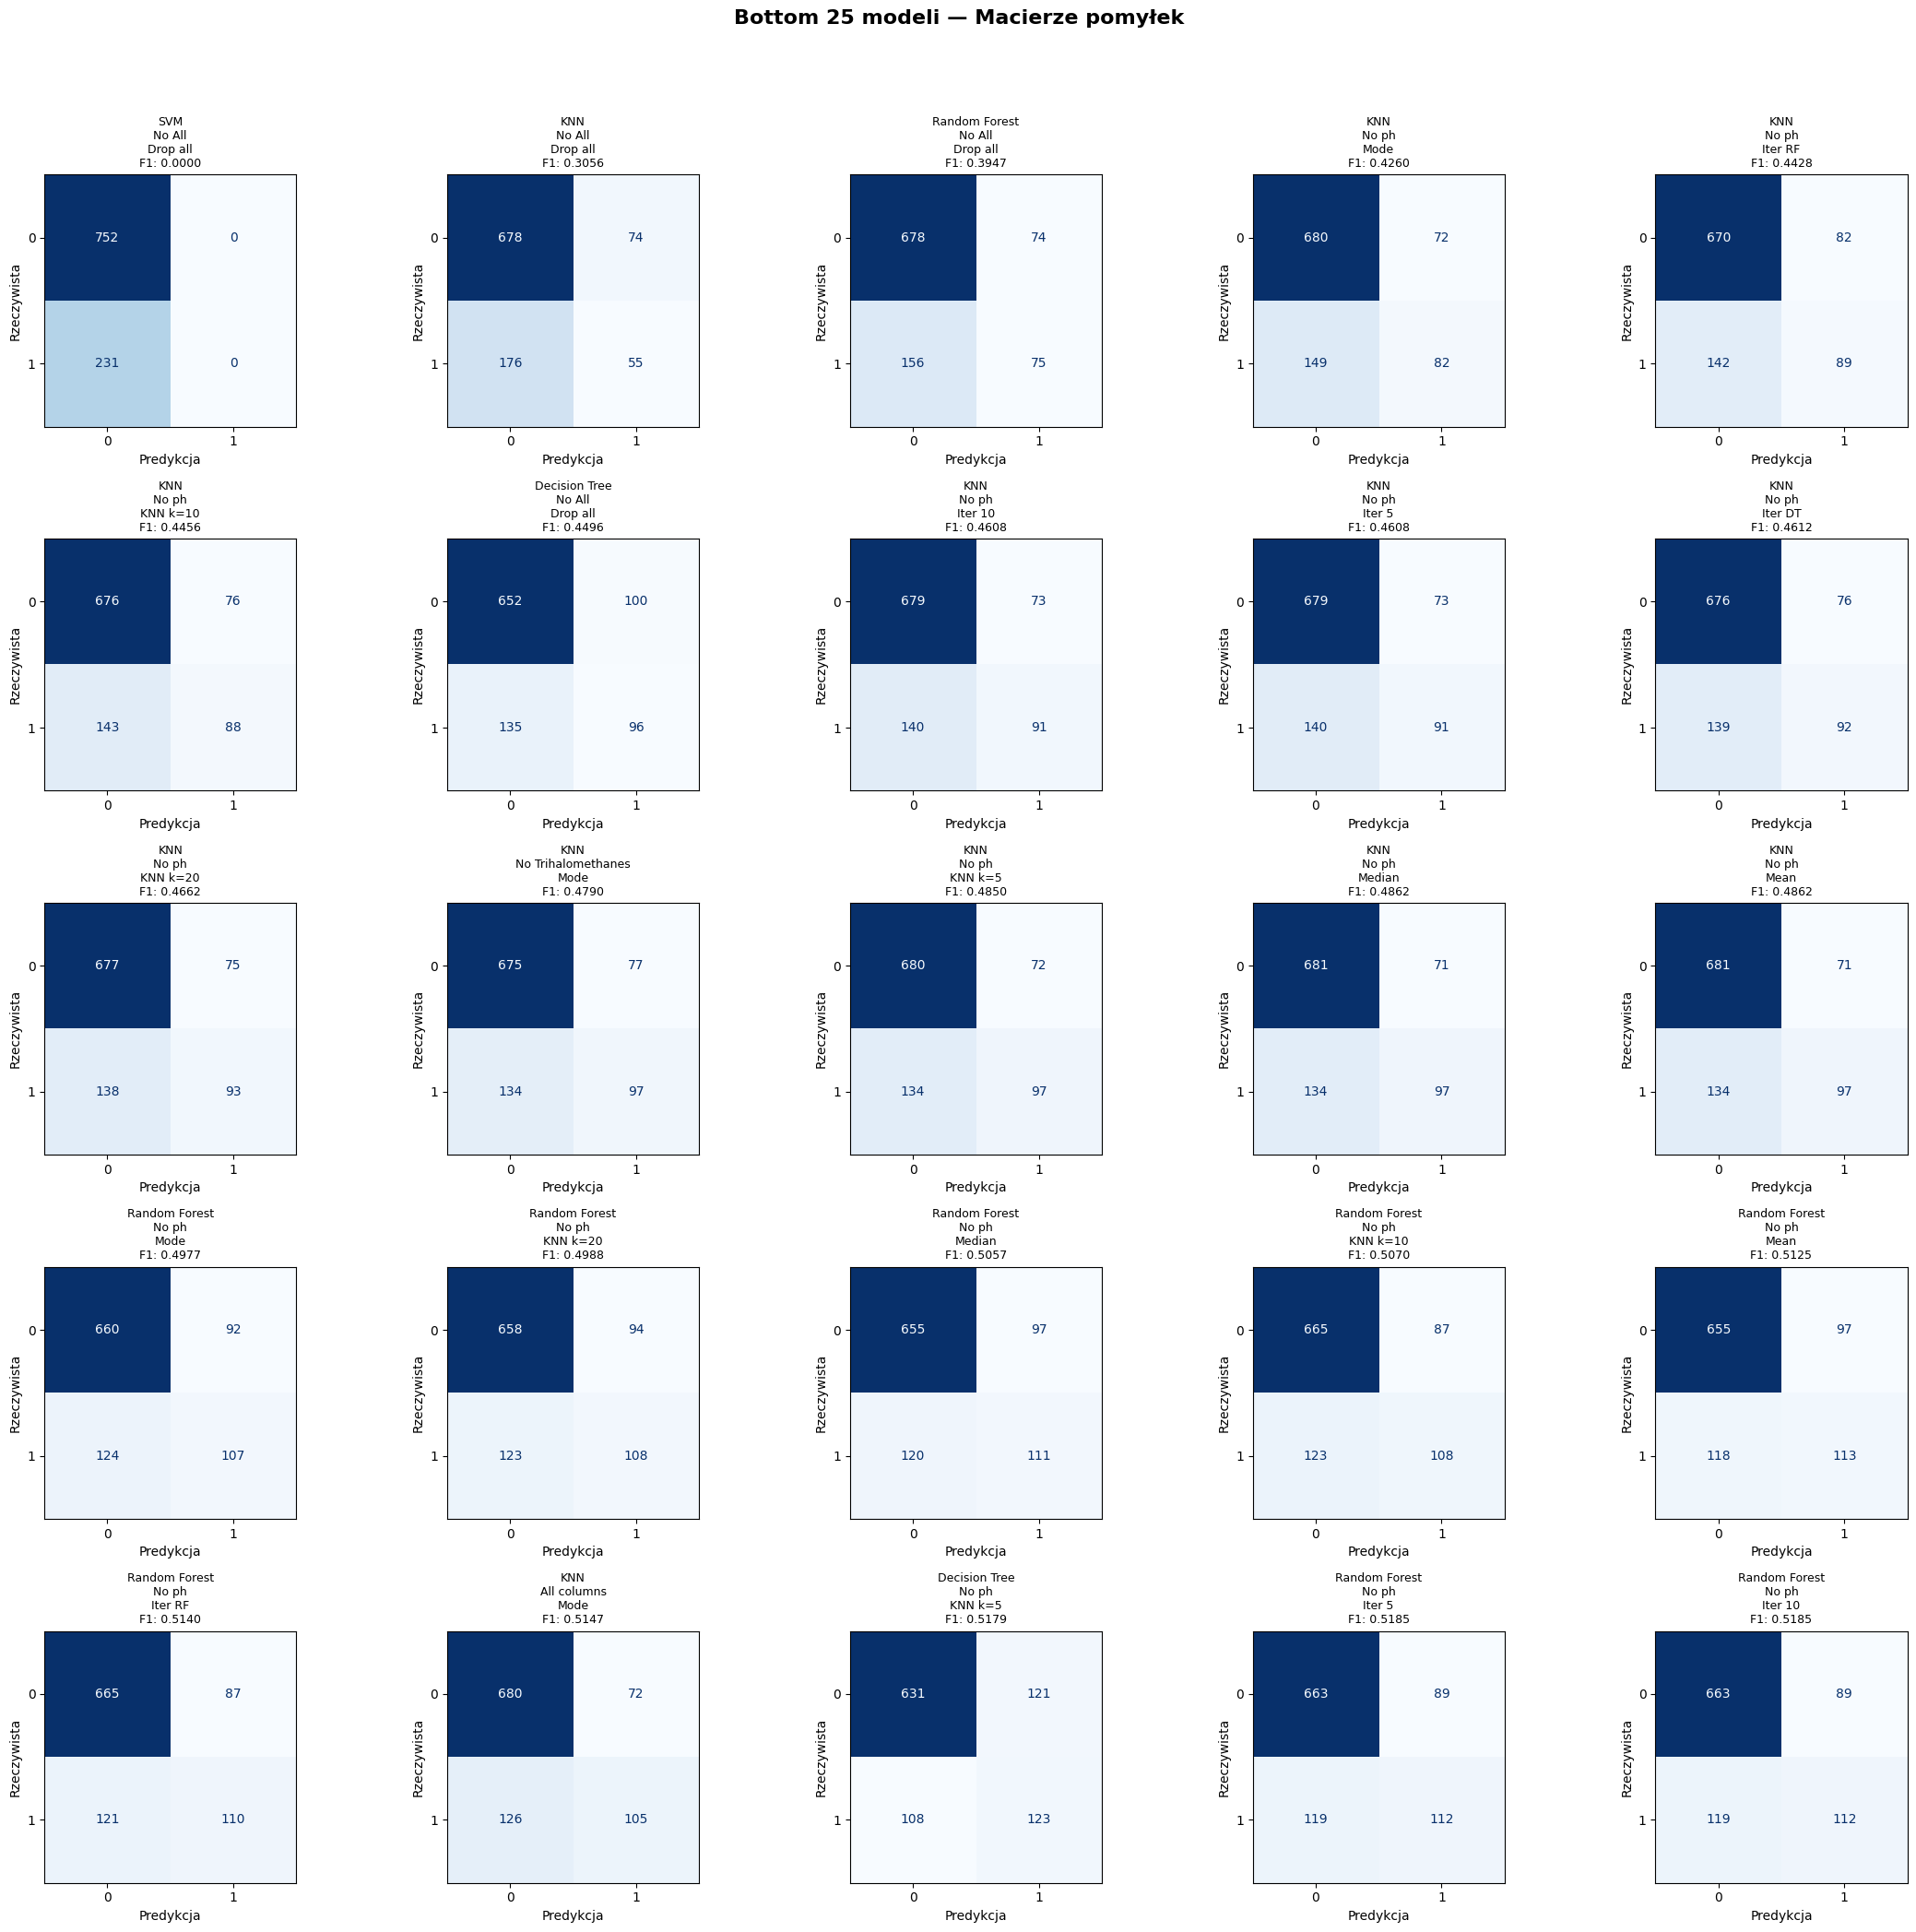

In [22]:
# Najgorsze 10 modeli wg F1-score
df_bottom25 = df_results.sort_values(by="F1-score", ascending=True).head(25).reset_index(drop=True)

# Wyświetlenie
print("Bottom 25 modeli wg F1-score:\n")
print(df_bottom25[["Model", "Zbiór", "F1-score"]])

# Macierze pomyłek dla bottom 10
fig, axes = plt.subplots(5, 5, figsize=(22, 22))
fig.suptitle("Bottom 25 modeli — Macierze pomyłek", fontsize=16, fontweight="bold")

for idx, row in df_bottom25.iterrows():
    model_name = row["Model"]
    zbior_label, imputacja_label = row["Zbiór"].split(" — ")

    for zbior_nazwa, metody in wszystkie_zbiory:
        if zbior_nazwa == zbior_label:
            for metoda_nazwa, X_train, X_test, y_train, y_test in metody:
                if metoda_nazwa == imputacja_label:
                    model = modele[model_name]
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    cm = confusion_matrix(y_test, y_pred)

                    ax = axes[idx // 5, idx % 5]

                    # ustawienie "tła" z odpowiednim vmax
                    im = ax.imshow(cm, interpolation='nearest', cmap='Blues', vmin=0, vmax=global_vmax)
                    
                    # wywołanie disp.plot(), które użyje już istniejącego obrazu
                    disp = ConfusionMatrixDisplay(cm)
                    disp.plot(ax=ax, cmap="Blues", values_format='d', colorbar=False)

                    ax.set_title(
                        f"{model_name}\n{zbior_label}\n{imputacja_label}\nF1: {row['F1-score']:.4f}",
                        fontsize=9
                    )
                    ax.set_xlabel("Predykcja")
                    ax.set_ylabel("Rzeczywista")
                    break

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
